In [1]:
# Imports
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import transforms
import sys
from __future__ import division

### 1. (30pts) Define functions

In [2]:
# One hot Encoding the categorical output values to binary by adding 1's for that index and 0's otherwise
def oneHotEncode(y):
    enc = pd.get_dummies(y['y'])
    return np.matrix(enc)

# Applying Sigmoid Activation function to the hidden layer outputs used while forward propagation
# works with scalar, arrays and matrix as well
# Purpose of this method is to do squishing on the linear function
def sigmoid(z):
    return 1./(1+np.exp(-z))

# Applying Sigmoid Activation function to the hidden layer outputs used while backward propagation to get gradients
# works with scalar, arrays and matrix as well
# Purpose of this method is to do undo the squishing on the linear function
def sigmoid_prime(z):
    inv = (np.exp(-z))/(np.power((1+np.exp(-z)),2))
    return inv

def relu(z):
    return np.maximum(z,0)
    
def relu_prime(z):
    return np.where(z < 0, 0.0, 1.0)

# Get the loss of for the training example
def get_cost(Y, Yhat):
    m= Y.shape[1]
    loss = np.multiply(np.log(Yhat),Y) + np.multiply((1.-Y), np.log(1. - Yhat))
    loss = np.sum(loss)
    cost = -1./m * np.sum(loss)
    cost = np.squeeze(cost)
    return cost

# Forward propagation to calculate yHat by applying activation function twice
def forward_propagate(cache, layerCount, activationFuncs):
    for l in range(1, layerCount+1):
        Zl =  'Z' + str(l)
        Al =  'A' + str(l)
        Wl =  'W' + str(l)
        Al1 = 'A' + str(l-1)
        bl =  'b' + str(l)
        cache[Zl] = np.dot(cache[Wl], cache[Al1]) + cache[bl]
        activationFunc = activationFuncs[l] + '(cache[Zl])'
        cache[Al] = eval(activationFunc)
    return cache

# Backward Propagation function to calculate the gradients
def back_propagate(cache, layerCount, deactivationFuncs):
    gradients = {}
    m = cache['A0'].shape[1]
    for l in xrange(layerCount, 0, -1):
        if(l==layerCount): # is last layer
            dZl = cache['A' + str(l)] - cache['A' + str(l+1)]    
        else:
            Zl = 'Z'+ str(l)
            dZl1 = 'dZ'+str(l+1)
            deacFunc = deactivationFuncs[l] + '(cache[Zl])'
            actv_prime = eval(deacFunc)
            term1 = cache['W'+str(l+1)].T
            term2 = gradients[dZl1]
            product = np.dot( term1, term2)
            dZl = np.multiply(product, actv_prime) 
        gradients['dZ' + str(l)] = dZl
        Al1 = cache['A' + str(l-1)]
#         print('--dZ'+str(l))
#         print(dZl.shape)
#         print('A'+str(l-1))
#         print( Al1.shape)
        dWl = (1./m) * np.dot(dZl, Al1.T)
        dbl = (1./m) * np.sum(dZl, axis=1)
#         print('dW' +str(l))
#         print(dWl.shape)
#         print('db' +str(l))
#         print(dbl.shape)
        gradients['dW' + str(l)] = dWl
        gradients['db' + str(l)] = dbl
    return gradients  


def gradientDescent(X, Y, YOrg, alpha, iters, hiddenLayers, layerSizes, activationFuncs, deactivationFuncs):  
    
    cache = initialize_parameters(hiddenLayers, layerSizes)
    cache['A0'] = X
    ykey = 'A' + str(hiddenLayers+1)
    cache[ykey] = Y
    old_cost = sys.maxsize
    new_cost = sys.maxsize
    cost_history = []
    for i in range(iters):
        # Call Forward propagation to calculate yHat
        cache = forward_propagate(cache, hiddenLayers, activationFuncs)
        old_cost = new_cost
        Afinal = cache['A'+str(hiddenLayers)]
        new_cost = get_cost(Y, cache['A'+str(hiddenLayers)])
        gradients = back_propagate(cache, hiddenLayers, deactivationFuncs)
        for l in range(1,hiddenLayers+1):
            Wl = cache['W'+str(l)]
            Wl = Wl - alpha * gradients['dW'+str(l)]
            cache['W'+str(l)] = Wl
            bl = cache['b'+str(l)]
            bl = bl - alpha * gradients['db'+str(l)]
            cache['b'+str(l)] = bl
        if(abs(old_cost - new_cost) < 0.00000000001):
            print("breaking" + str(old_cost) + str(new_cost))
            break;
        print ("cost : " + str(new_cost) + " Old cost : " + str(old_cost) + " Iteration: " + str(i))
        cost_history.append(new_cost)
    Afinal = softmax(Afinal) # Apply softmax to get the actual labels
    cache['A'+str(hiddenLayers)] = Afinal
    accuracy = get_accuracy(YOrg, Afinal)
    return cache, cost_history, new_cost, accuracy

# Softmax activation function to get the probablity of the classes
def softmax(z):
    softMax = (np.exp(z) / np.sum(np.exp(z),axis=0))
    softMax = np.matrix(np.argmax(softMax,axis=0)).T
    return softMax

def plotCostHistory(cost_history, alpha, i):
     line = plt.plot(cost_history, label=alpha)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations for different learning rates')
     plt.legend()
        
def get_accuracy(Y, Ypred):
    Y = np.matrix(Y)
    numcorrect = 0
    for (x,y) in zip(Ypred,Y):
        if(x[0]==y[0]):
            numcorrect+=1
    accuracy=numcorrect*100.0/len(Y)
    return accuracy

### 2. Split data

In [3]:
# Reading the training data
data_train = pd.read_csv('exam1_train.csv', sep=",", encoding='utf-8', header='infer')
# Remove the un-necessary column
df_train = data_train.drop('Unnamed: 0',axis=1)
m = df_train.shape[0]

y_train = pd.DataFrame(df_train['y'])
X_train = df_train.drop(['y'], axis=1)

X_train_mat = np.matrix(X_train).T
y_train_mat = oneHotEncode(y_train).T

     y
202  4


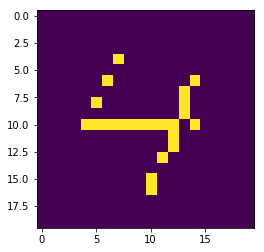

In [4]:
# Reading the test data
data_test = pd.read_csv('exam1_test.csv', sep=",", encoding='utf-8', header='infer')
# Remove the un-necessary column
df_test = data_test.drop('Unnamed: 0',axis=1)

y_test = pd.DataFrame(df_test['y'])
X_test = df_test.drop(['y'], axis=1)

X_test_mat = np.matrix(X_test).T
y_test_mat = oneHotEncode(y_test).T

# Plot the selected pixel
num = 202
pixels = np.array(X_test[num:num+1], dtype='uint8')
print(y_test[num:num+1])
pixels = pixels.reshape((20, 20)).T
plt.imshow(pixels)
plt.show()

### 3. (10pts) Initialize parameters

In [5]:
# Initialize weights // TODO - change the initialization method

np.random.seed(1) # Setting random seed to 1
def initialize_parameters(hiddenLayers, layerSizes):
    cache = {}
    for l in range(1,hiddenLayers+1):
        #print(l)
        Wl = 'W' + str(l)
        bl = 'b' + str(l)
        #print(layerSizes[l])
        #print(layerSizes[l-1])
        cache[Wl] =  np.random.randn(layerSizes[l], layerSizes[l-1]) * 0.01
        cache[bl] =  np.zeros((layerSizes[l],1))
        l=l+1
    #print(cache)
    return cache

### 4. (30pts) Deep Neural Network model with more than 2 hidden layers

In [6]:
# Defining Hyperparameters
hiddenLayers = 3
layerSizes = [400, 25, 25, 10] # As specified in assignment requirements, can have as many hidden layers
print(" Number of hidden layers including output layer are - " + str(hiddenLayers))
activationFuncs = ['', 'relu', 'relu','sigmoid']
deactivationFuncs = ['', 'relu_prime', 'relu_prime','sigmoid_prime']

 Number of hidden layers including output layer are - 3


In [7]:
# cache = initialize_parameters(hiddenLayers, layerSizes)
# print(cache['W1'].shape)
# # print(cache['W2'].shape)
# # print(cache['W3'].shape)
# # print(cache['b1'].shape)
# # print(cache['b2'].shape)
# # print(cache['b3'].shape)
# cache['A0'] = X_train_mat
# ykey = 'A' + str(len(layerSizes))
# cache[ykey] = y_train_mat
# cache = forward_propagate(cache, hiddenLayers, ['', 'apply_sigmoid', 'apply_sigmoid','apply_sigmoid'])
# # print(cache['A1'])
# # print(cache['A2'])
# # print(cache['A3'])
# # print(cache['Z2'])

In [8]:
# gradients = back_propagate(cache, hiddenLayers, deactivationFuncs)

### 5. (10pts) Predictions

### 6. (20pts) Optimization

In [9]:
# Optimization function to check cost propagartion for different learning rates
def optimize():
    alpha = [1, 0.1]
    i=0
    scores = pd.DataFrame(columns=['alpha','cache','accuracy'])
    print('*****************Training Data*********************')
    for a in alpha:
        cache, cost_history, new_cost, acc = gradientDescent(X_train_mat, y_train_mat, 
                                                y_train, a, 8000, hiddenLayers, layerSizes, activationFuncs, deactivationFuncs)
        scores.loc[i] = pd.Series({'alpha':a, 'cache': cache, 'accuracy':acc})
        print("Cost with " + "Alpha " + str(a) + " is " + str(new_cost) + " & " + "Accuracy is " + str(acc) + " %")
        plotCostHistory(cost_history, a, i)
        i+=1
    least_cost_comb = scores['accuracy'].idxmax()
    alph = scores.iloc[[least_cost_comb]]['alpha'][least_cost_comb]
    cache = scores.iloc[[least_cost_comb]]['cache'][least_cost_comb]
    plt.show()
    return cache, alph

*****************Training Data*********************
cost : 6.93138507811 Old cost : 9223372036854775807 Iteration: 0
cost : 5.52825003584 Old cost : 6.93138507811 Iteration: 1
cost : 4.72339400519 Old cost : 5.52825003584 Iteration: 2
cost : 4.23775536651 Old cost : 4.72339400519 Iteration: 3
cost : 3.92474649038 Old cost : 4.23775536651 Iteration: 4
cost : 3.70681143728 Old cost : 3.92474649038 Iteration: 5
cost : 3.53923795053 Old cost : 3.70681143728 Iteration: 6
cost : 3.39326036175 Old cost : 3.53923795053 Iteration: 7
cost : 3.27618234857 Old cost : 3.39326036175 Iteration: 8
cost : 3.25338419154 Old cost : 3.27618234857 Iteration: 9
cost : 3.2514794434 Old cost : 3.25338419154 Iteration: 10
cost : 3.25019154492 Old cost : 3.2514794434 Iteration: 11
cost : 3.24919353112 Old cost : 3.25019154492 Iteration: 12
cost : 3.24818327718 Old cost : 3.24919353112 Iteration: 13
cost : 3.24709516837 Old cost : 3.24818327718 Iteration: 14
cost : 3.24587927078 Old cost : 3.24709516837 Iteratio

cost : 2.43019228222 Old cost : 2.69185099371 Iteration: 137
cost : 2.36714258245 Old cost : 2.43019228222 Iteration: 138
cost : 2.414932603 Old cost : 2.36714258245 Iteration: 139
cost : 2.37468167095 Old cost : 2.414932603 Iteration: 140
cost : 2.5011254769 Old cost : 2.37468167095 Iteration: 141
cost : 2.29483211778 Old cost : 2.5011254769 Iteration: 142
cost : 2.24206414388 Old cost : 2.29483211778 Iteration: 143
cost : 2.23887501102 Old cost : 2.24206414388 Iteration: 144
cost : 2.31041966547 Old cost : 2.23887501102 Iteration: 145
cost : 3.00618878508 Old cost : 2.31041966547 Iteration: 146
cost : 3.14101215342 Old cost : 3.00618878508 Iteration: 147
cost : 2.85660532845 Old cost : 3.14101215342 Iteration: 148
cost : 2.8157178128 Old cost : 2.85660532845 Iteration: 149
cost : 2.85615060566 Old cost : 2.8157178128 Iteration: 150
cost : 2.89976915131 Old cost : 2.85615060566 Iteration: 151
cost : 2.84051456544 Old cost : 2.89976915131 Iteration: 152
cost : 2.70048124274 Old cost : 

cost : 1.74334021281 Old cost : 1.72685011828 Iteration: 289
cost : 2.33690108843 Old cost : 1.74334021281 Iteration: 290
cost : 2.11666333895 Old cost : 2.33690108843 Iteration: 291
cost : 1.99990241772 Old cost : 2.11666333895 Iteration: 292
cost : 1.70028642648 Old cost : 1.99990241772 Iteration: 293
cost : 1.78072192693 Old cost : 1.70028642648 Iteration: 294
cost : 1.67737841645 Old cost : 1.78072192693 Iteration: 295
cost : 1.50598115406 Old cost : 1.67737841645 Iteration: 296
cost : 1.61750485543 Old cost : 1.50598115406 Iteration: 297
cost : 1.52593391461 Old cost : 1.61750485543 Iteration: 298
cost : 1.6809079134 Old cost : 1.52593391461 Iteration: 299
cost : 1.62525179019 Old cost : 1.6809079134 Iteration: 300
cost : 1.60346920255 Old cost : 1.62525179019 Iteration: 301
cost : 1.45858573238 Old cost : 1.60346920255 Iteration: 302
cost : 1.39323390896 Old cost : 1.45858573238 Iteration: 303
cost : 1.38682199984 Old cost : 1.39323390896 Iteration: 304
cost : 1.47204563877 Old c

cost : 1.29127062146 Old cost : 1.71551157556 Iteration: 431
cost : 1.19036722281 Old cost : 1.29127062146 Iteration: 432
cost : 1.1137113133 Old cost : 1.19036722281 Iteration: 433
cost : 1.21585234073 Old cost : 1.1137113133 Iteration: 434
cost : 1.15004561136 Old cost : 1.21585234073 Iteration: 435
cost : 1.31335182123 Old cost : 1.15004561136 Iteration: 436
cost : 1.09221056333 Old cost : 1.31335182123 Iteration: 437
cost : 1.09500091181 Old cost : 1.09221056333 Iteration: 438
cost : 1.03599294238 Old cost : 1.09500091181 Iteration: 439
cost : 1.02499628704 Old cost : 1.03599294238 Iteration: 440
cost : 1.02233627904 Old cost : 1.02499628704 Iteration: 441
cost : 1.02242887504 Old cost : 1.02233627904 Iteration: 442
cost : 1.04666788979 Old cost : 1.02242887504 Iteration: 443
cost : 1.08014607023 Old cost : 1.04666788979 Iteration: 444
cost : 1.14413775854 Old cost : 1.08014607023 Iteration: 445
cost : 1.252511357 Old cost : 1.14413775854 Iteration: 446
cost : 1.327648869 Old cost 

cost : 0.819642219717 Old cost : 0.802582985256 Iteration: 570
cost : 0.93409528846 Old cost : 0.819642219717 Iteration: 571
cost : 1.16567649656 Old cost : 0.93409528846 Iteration: 572
cost : 1.69360847654 Old cost : 1.16567649656 Iteration: 573
cost : 2.29743996746 Old cost : 1.69360847654 Iteration: 574
cost : 2.36536166636 Old cost : 2.29743996746 Iteration: 575
cost : 1.77114416292 Old cost : 2.36536166636 Iteration: 576
cost : 1.07086924763 Old cost : 1.77114416292 Iteration: 577
cost : 0.913084401709 Old cost : 1.07086924763 Iteration: 578
cost : 0.825284379066 Old cost : 0.913084401709 Iteration: 579
cost : 0.815281901355 Old cost : 0.825284379066 Iteration: 580
cost : 0.833190497008 Old cost : 0.815281901355 Iteration: 581
cost : 1.131810347 Old cost : 0.833190497008 Iteration: 582
cost : 0.885656301144 Old cost : 1.131810347 Iteration: 583
cost : 0.93026391318 Old cost : 0.885656301144 Iteration: 584
cost : 0.820062189064 Old cost : 0.93026391318 Iteration: 585
cost : 0.86631

cost : 0.603991833377 Old cost : 0.562211680467 Iteration: 703
cost : 0.610834469692 Old cost : 0.603991833377 Iteration: 704
cost : 0.709188615597 Old cost : 0.610834469692 Iteration: 705
cost : 0.805958471492 Old cost : 0.709188615597 Iteration: 706
cost : 1.25972163265 Old cost : 0.805958471492 Iteration: 707
cost : 0.969260603578 Old cost : 1.25972163265 Iteration: 708
cost : 0.715175786245 Old cost : 0.969260603578 Iteration: 709
cost : 0.699174528705 Old cost : 0.715175786245 Iteration: 710
cost : 0.62284437649 Old cost : 0.699174528705 Iteration: 711
cost : 0.753132382419 Old cost : 0.62284437649 Iteration: 712
cost : 0.65590716649 Old cost : 0.753132382419 Iteration: 713
cost : 0.815036442579 Old cost : 0.65590716649 Iteration: 714
cost : 0.642010010753 Old cost : 0.815036442579 Iteration: 715
cost : 0.749684711244 Old cost : 0.642010010753 Iteration: 716
cost : 0.653941353076 Old cost : 0.749684711244 Iteration: 717
cost : 0.728321877463 Old cost : 0.653941353076 Iteration: 71

/Users/meenakshiparyani/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/Users/meenakshiparyani/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


cost : 1.16555447245 Old cost : 1.0490749258 Iteration: 762
cost : 0.96967238201 Old cost : 1.16555447245 Iteration: 763
cost : 1.0872750216 Old cost : 0.96967238201 Iteration: 764
cost : 0.953755665788 Old cost : 1.0872750216 Iteration: 765
cost : 1.15650020099 Old cost : 0.953755665788 Iteration: 766
cost : 0.868424721803 Old cost : 1.15650020099 Iteration: 767
cost : 0.994610200177 Old cost : 0.868424721803 Iteration: 768
cost : 0.957264468969 Old cost : 0.994610200177 Iteration: 769
cost : 1.27326568776 Old cost : 0.957264468969 Iteration: 770
cost : 0.787068338209 Old cost : 1.27326568776 Iteration: 771
cost : 0.764536418718 Old cost : 0.787068338209 Iteration: 772
cost : 0.793087778958 Old cost : 0.764536418718 Iteration: 773
cost : 0.847097994163 Old cost : 0.793087778958 Iteration: 774
cost : 0.998727599953 Old cost : 0.847097994163 Iteration: 775
cost : 1.04378189923 Old cost : 0.998727599953 Iteration: 776
cost : 1.48583066862 Old cost : 1.04378189923 Iteration: 777
cost : 1.

cost : 1.00870854799 Old cost : 1.00037977993 Iteration: 912
cost : 0.999037164034 Old cost : 1.00870854799 Iteration: 913
cost : 1.01972420713 Old cost : 0.999037164034 Iteration: 914
cost : 1.00174325253 Old cost : 1.01972420713 Iteration: 915
cost : 1.033884071 Old cost : 1.00174325253 Iteration: 916
cost : 1.01005677687 Old cost : 1.033884071 Iteration: 917
cost : 1.04927569829 Old cost : 1.01005677687 Iteration: 918
cost : 1.03659032114 Old cost : 1.04927569829 Iteration: 919
cost : 1.09691911448 Old cost : 1.03659032114 Iteration: 920
cost : 1.14743967426 Old cost : 1.09691911448 Iteration: 921
cost : nan Old cost : 1.14743967426 Iteration: 922
cost : 2.23466871164 Old cost : nan Iteration: 923
cost : 1.36196812788 Old cost : 2.23466871164 Iteration: 924
cost : 1.29209110995 Old cost : 1.36196812788 Iteration: 925
cost : 1.15843985614 Old cost : 1.29209110995 Iteration: 926
cost : 1.17829169189 Old cost : 1.15843985614 Iteration: 927
cost : 1.08705421662 Old cost : 1.17829169189 

cost : 1.66101682443 Old cost : 1.91657206717 Iteration: 1054
cost : 1.01379423171 Old cost : 1.66101682443 Iteration: 1055
cost : 0.780044367902 Old cost : 1.01379423171 Iteration: 1056
cost : 0.696186106987 Old cost : 0.780044367902 Iteration: 1057
cost : 0.656875240732 Old cost : 0.696186106987 Iteration: 1058
cost : 0.633323811025 Old cost : 0.656875240732 Iteration: 1059
cost : 0.617610763028 Old cost : 0.633323811025 Iteration: 1060
cost : 0.605925564886 Old cost : 0.617610763028 Iteration: 1061
cost : 0.597993586359 Old cost : 0.605925564886 Iteration: 1062
cost : 0.591137077001 Old cost : 0.597993586359 Iteration: 1063
cost : 0.584743390528 Old cost : 0.591137077001 Iteration: 1064
cost : 0.580190726515 Old cost : 0.584743390528 Iteration: 1065
cost : 0.575963897758 Old cost : 0.580190726515 Iteration: 1066
cost : 0.573560024089 Old cost : 0.575963897758 Iteration: 1067
cost : 0.574375285164 Old cost : 0.573560024089 Iteration: 1068
cost : 0.575142180216 Old cost : 0.5743752851

cost : 0.479150081969 Old cost : 0.491645662835 Iteration: 1204
cost : 0.542346936593 Old cost : 0.479150081969 Iteration: 1205
cost : 0.53298501692 Old cost : 0.542346936593 Iteration: 1206
cost : 0.714611308408 Old cost : 0.53298501692 Iteration: 1207
cost : nan Old cost : 0.714611308408 Iteration: 1208
cost : 1.75806859274 Old cost : nan Iteration: 1209
cost : 0.884505962675 Old cost : 1.75806859274 Iteration: 1210
cost : 1.41976596359 Old cost : 0.884505962675 Iteration: 1211
cost : 1.46582472446 Old cost : 1.41976596359 Iteration: 1212
cost : 1.68845387742 Old cost : 1.46582472446 Iteration: 1213
cost : 1.08461996286 Old cost : 1.68845387742 Iteration: 1214
cost : 1.10031470457 Old cost : 1.08461996286 Iteration: 1215
cost : 0.661311802671 Old cost : 1.10031470457 Iteration: 1216
cost : 0.493210001476 Old cost : 0.661311802671 Iteration: 1217
cost : 0.465368117865 Old cost : 0.493210001476 Iteration: 1218
cost : 0.446316368258 Old cost : 0.465368117865 Iteration: 1219
cost : 0.435

cost : 0.346525439985 Old cost : 0.340423651891 Iteration: 1340
cost : 0.339747089175 Old cost : 0.346525439985 Iteration: 1341
cost : 0.345718559827 Old cost : 0.339747089175 Iteration: 1342
cost : 0.339630642962 Old cost : 0.345718559827 Iteration: 1343
cost : 0.346811439757 Old cost : 0.339630642962 Iteration: 1344
cost : 0.342304407523 Old cost : 0.346811439757 Iteration: 1345
cost : 0.34977214149 Old cost : 0.342304407523 Iteration: 1346
cost : 0.347378896261 Old cost : 0.34977214149 Iteration: 1347
cost : 0.349072995922 Old cost : 0.347378896261 Iteration: 1348
cost : 0.351314505065 Old cost : 0.349072995922 Iteration: 1349
cost : 0.352447782669 Old cost : 0.351314505065 Iteration: 1350
cost : 0.360839595487 Old cost : 0.352447782669 Iteration: 1351
cost : 0.364054501063 Old cost : 0.360839595487 Iteration: 1352
cost : 0.377651412188 Old cost : 0.364054501063 Iteration: 1353
cost : 0.376161982353 Old cost : 0.377651412188 Iteration: 1354
cost : 0.39457043216 Old cost : 0.37616198

cost : 1.25995370662 Old cost : 1.29800719114 Iteration: 1480
cost : 1.21090598117 Old cost : 1.25995370662 Iteration: 1481
cost : 1.30372539248 Old cost : 1.21090598117 Iteration: 1482
cost : 1.25366702747 Old cost : 1.30372539248 Iteration: 1483
cost : 1.84410076351 Old cost : 1.25366702747 Iteration: 1484
cost : nan Old cost : 1.84410076351 Iteration: 1485
cost : 2.37285667134 Old cost : nan Iteration: 1486
cost : 1.38798875596 Old cost : 2.37285667134 Iteration: 1487
cost : 1.17418798622 Old cost : 1.38798875596 Iteration: 1488
cost : 1.04731099156 Old cost : 1.17418798622 Iteration: 1489
cost : 0.909363205128 Old cost : 1.04731099156 Iteration: 1490
cost : 0.877288543907 Old cost : 0.909363205128 Iteration: 1491
cost : 0.857281825088 Old cost : 0.877288543907 Iteration: 1492
cost : 0.855345371162 Old cost : 0.857281825088 Iteration: 1493
cost : 0.957617047161 Old cost : 0.855345371162 Iteration: 1494
cost : 0.938054798183 Old cost : 0.957617047161 Iteration: 1495
cost : 0.98931196

cost : 0.524875532281 Old cost : 0.443708743693 Iteration: 1614
cost : 0.473819562678 Old cost : 0.524875532281 Iteration: 1615
cost : 0.631466458176 Old cost : 0.473819562678 Iteration: 1616
cost : 0.550584798411 Old cost : 0.631466458176 Iteration: 1617
cost : 0.930796442878 Old cost : 0.550584798411 Iteration: 1618
cost : nan Old cost : 0.930796442878 Iteration: 1619
cost : 1.82211079523 Old cost : nan Iteration: 1620
cost : nan Old cost : 1.82211079523 Iteration: 1621
cost : 0.818370168173 Old cost : nan Iteration: 1622
cost : 0.78454675524 Old cost : 0.818370168173 Iteration: 1623
cost : nan Old cost : 0.78454675524 Iteration: 1624
cost : 1.36306000175 Old cost : nan Iteration: 1625
cost : nan Old cost : 1.36306000175 Iteration: 1626
cost : 1.64936904202 Old cost : nan Iteration: 1627
cost : 1.00511945812 Old cost : 1.64936904202 Iteration: 1628
cost : 1.45435721386 Old cost : 1.00511945812 Iteration: 1629
cost : 1.81927272905 Old cost : 1.45435721386 Iteration: 1630
cost : 2.0594

cost : 0.278202501204 Old cost : 0.28010021164 Iteration: 1761
cost : 0.27649617451 Old cost : 0.278202501204 Iteration: 1762
cost : 0.274909221569 Old cost : 0.27649617451 Iteration: 1763
cost : 0.27350846011 Old cost : 0.274909221569 Iteration: 1764
cost : 0.272268506578 Old cost : 0.27350846011 Iteration: 1765
cost : 0.271431091367 Old cost : 0.272268506578 Iteration: 1766
cost : 0.270743689971 Old cost : 0.271431091367 Iteration: 1767
cost : 0.271044194269 Old cost : 0.270743689971 Iteration: 1768
cost : 0.270613615246 Old cost : 0.271044194269 Iteration: 1769
cost : 0.273191723269 Old cost : 0.270613615246 Iteration: 1770
cost : 0.273327598941 Old cost : 0.273191723269 Iteration: 1771
cost : 0.281278016303 Old cost : 0.273327598941 Iteration: 1772
cost : 0.275605959997 Old cost : 0.281278016303 Iteration: 1773
cost : 0.284099381963 Old cost : 0.275605959997 Iteration: 1774
cost : 0.277416950396 Old cost : 0.284099381963 Iteration: 1775
cost : 0.289504777367 Old cost : 0.2774169503

cost : 0.244023287369 Old cost : 0.255044484482 Iteration: 1913
cost : 0.238946913852 Old cost : 0.244023287369 Iteration: 1914
cost : 0.234130887098 Old cost : 0.238946913852 Iteration: 1915
cost : 0.231052399195 Old cost : 0.234130887098 Iteration: 1916
cost : 0.228710680024 Old cost : 0.231052399195 Iteration: 1917
cost : 0.226801939752 Old cost : 0.228710680024 Iteration: 1918
cost : 0.224961194391 Old cost : 0.226801939752 Iteration: 1919
cost : 0.223275677191 Old cost : 0.224961194391 Iteration: 1920
cost : 0.221699198862 Old cost : 0.223275677191 Iteration: 1921
cost : 0.220111335904 Old cost : 0.221699198862 Iteration: 1922
cost : 0.218619696022 Old cost : 0.220111335904 Iteration: 1923
cost : 0.217337223228 Old cost : 0.218619696022 Iteration: 1924
cost : 0.215832996691 Old cost : 0.217337223228 Iteration: 1925
cost : 0.214791223134 Old cost : 0.215832996691 Iteration: 1926
cost : 0.213633630378 Old cost : 0.214791223134 Iteration: 1927
cost : 0.212707508922 Old cost : 0.21363

cost : 0.238080945504 Old cost : 0.243520558732 Iteration: 2048
cost : 0.211923678353 Old cost : 0.238080945504 Iteration: 2049
cost : 0.207046645875 Old cost : 0.211923678353 Iteration: 2050
cost : 0.197730075135 Old cost : 0.207046645875 Iteration: 2051
cost : 0.193893339564 Old cost : 0.197730075135 Iteration: 2052
cost : 0.187552820525 Old cost : 0.193893339564 Iteration: 2053
cost : 0.184144712559 Old cost : 0.187552820525 Iteration: 2054
cost : 0.181097061914 Old cost : 0.184144712559 Iteration: 2055
cost : 0.178756798581 Old cost : 0.181097061914 Iteration: 2056
cost : 0.176636335827 Old cost : 0.178756798581 Iteration: 2057
cost : 0.175269621634 Old cost : 0.176636335827 Iteration: 2058
cost : 0.173889073524 Old cost : 0.175269621634 Iteration: 2059
cost : 0.172995534343 Old cost : 0.173889073524 Iteration: 2060
cost : 0.171985932892 Old cost : 0.172995534343 Iteration: 2061
cost : 0.171320818752 Old cost : 0.171985932892 Iteration: 2062
cost : 0.170368421108 Old cost : 0.17132

cost : 2.23512825571 Old cost : 2.2763969502 Iteration: 2194
cost : 1.80510923399 Old cost : 2.23512825571 Iteration: 2195
cost : 1.80228457571 Old cost : 1.80510923399 Iteration: 2196
cost : 1.80093158138 Old cost : 1.80228457571 Iteration: 2197
cost : 1.85766162353 Old cost : 1.80093158138 Iteration: 2198
cost : 1.80249088623 Old cost : 1.85766162353 Iteration: 2199
cost : 1.81081718162 Old cost : 1.80249088623 Iteration: 2200
cost : 1.76620963518 Old cost : 1.81081718162 Iteration: 2201
cost : 1.83655579609 Old cost : 1.76620963518 Iteration: 2202
cost : 1.78101416103 Old cost : 1.83655579609 Iteration: 2203
cost : 1.92006320722 Old cost : 1.78101416103 Iteration: 2204
cost : 1.70977980395 Old cost : 1.92006320722 Iteration: 2205
cost : 1.71378068231 Old cost : 1.70977980395 Iteration: 2206
cost : 1.72869958646 Old cost : 1.71378068231 Iteration: 2207
cost : 1.90306231605 Old cost : 1.72869958646 Iteration: 2208
cost : 1.69485918964 Old cost : 1.90306231605 Iteration: 2209
cost : 1.

cost : 1.20402437884 Old cost : 1.15158934138 Iteration: 2346
cost : 1.24967826217 Old cost : 1.20402437884 Iteration: 2347
cost : 1.27020447771 Old cost : 1.24967826217 Iteration: 2348
cost : 1.34557819573 Old cost : 1.27020447771 Iteration: 2349
cost : 1.19280212326 Old cost : 1.34557819573 Iteration: 2350
cost : 1.19070464965 Old cost : 1.19280212326 Iteration: 2351
cost : 1.11303860787 Old cost : 1.19070464965 Iteration: 2352
cost : 1.09598402135 Old cost : 1.11303860787 Iteration: 2353
cost : 1.07333869266 Old cost : 1.09598402135 Iteration: 2354
cost : 1.08021014753 Old cost : 1.07333869266 Iteration: 2355
cost : 1.10323120264 Old cost : 1.08021014753 Iteration: 2356
cost : 1.18932134258 Old cost : 1.10323120264 Iteration: 2357
cost : 1.18237157625 Old cost : 1.18932134258 Iteration: 2358
cost : 1.3678363602 Old cost : 1.18237157625 Iteration: 2359
cost : 1.135426876 Old cost : 1.3678363602 Iteration: 2360
cost : 1.27118631961 Old cost : 1.135426876 Iteration: 2361
cost : 1.04798

cost : 1.03474122803 Old cost : 0.961100281803 Iteration: 2481
cost : 0.980133003081 Old cost : 1.03474122803 Iteration: 2482
cost : 1.15365066317 Old cost : 0.980133003081 Iteration: 2483
cost : 0.978082321284 Old cost : 1.15365066317 Iteration: 2484
cost : 1.09660624727 Old cost : 0.978082321284 Iteration: 2485
cost : 0.960649238259 Old cost : 1.09660624727 Iteration: 2486
cost : 1.07848134775 Old cost : 0.960649238259 Iteration: 2487
cost : 0.978636966855 Old cost : 1.07848134775 Iteration: 2488
cost : 1.06928681643 Old cost : 0.978636966855 Iteration: 2489
cost : 0.943816547596 Old cost : 1.06928681643 Iteration: 2490
cost : 1.01041626096 Old cost : 0.943816547596 Iteration: 2491
cost : 0.965636294206 Old cost : 1.01041626096 Iteration: 2492
cost : 1.14352538739 Old cost : 0.965636294206 Iteration: 2493
cost : 0.977270267388 Old cost : 1.14352538739 Iteration: 2494
cost : 1.13434116594 Old cost : 0.977270267388 Iteration: 2495
cost : 1.05912051209 Old cost : 1.13434116594 Iteration

cost : 1.10501720827 Old cost : 1.21339476224 Iteration: 2629
cost : 1.579705205 Old cost : 1.10501720827 Iteration: 2630
cost : nan Old cost : 1.579705205 Iteration: 2631
cost : 1.28169598882 Old cost : nan Iteration: 2632
cost : 1.03492568222 Old cost : 1.28169598882 Iteration: 2633
cost : 1.18592722446 Old cost : 1.03492568222 Iteration: 2634
cost : 0.915495949484 Old cost : 1.18592722446 Iteration: 2635
cost : 0.993028315954 Old cost : 0.915495949484 Iteration: 2636
cost : 0.899513323775 Old cost : 0.993028315954 Iteration: 2637
cost : 0.966336781157 Old cost : 0.899513323775 Iteration: 2638
cost : 0.873689694433 Old cost : 0.966336781157 Iteration: 2639
cost : 0.891514793749 Old cost : 0.873689694433 Iteration: 2640
cost : 0.833397635794 Old cost : 0.891514793749 Iteration: 2641
cost : 0.868511441313 Old cost : 0.833397635794 Iteration: 2642
cost : 0.81385835831 Old cost : 0.868511441313 Iteration: 2643
cost : 0.855315771616 Old cost : 0.81385835831 Iteration: 2644
cost : 0.800829

cost : 0.7738592812 Old cost : 0.777838385003 Iteration: 2782
cost : 0.824770999108 Old cost : 0.7738592812 Iteration: 2783
cost : 0.826599360654 Old cost : 0.824770999108 Iteration: 2784
cost : 0.880715777358 Old cost : 0.826599360654 Iteration: 2785
cost : 1.00007987624 Old cost : 0.880715777358 Iteration: 2786
cost : 0.87621351143 Old cost : 1.00007987624 Iteration: 2787
cost : 0.867883996531 Old cost : 0.87621351143 Iteration: 2788
cost : 0.833185408749 Old cost : 0.867883996531 Iteration: 2789
cost : 0.851921817984 Old cost : 0.833185408749 Iteration: 2790
cost : 0.81113945172 Old cost : 0.851921817984 Iteration: 2791
cost : 0.846634393035 Old cost : 0.81113945172 Iteration: 2792
cost : 0.804890087708 Old cost : 0.846634393035 Iteration: 2793
cost : 0.817761558881 Old cost : 0.804890087708 Iteration: 2794
cost : 0.794685736643 Old cost : 0.817761558881 Iteration: 2795
cost : 0.785500401726 Old cost : 0.794685736643 Iteration: 2796
cost : 0.781169031022 Old cost : 0.785500401726 It

cost : 0.780093424702 Old cost : 0.831765561343 Iteration: 2927
cost : 0.898396134148 Old cost : 0.780093424702 Iteration: 2928
cost : 0.882955927763 Old cost : 0.898396134148 Iteration: 2929
cost : 1.17646613695 Old cost : 0.882955927763 Iteration: 2930
cost : 0.984182035377 Old cost : 1.17646613695 Iteration: 2931
cost : 1.31216457261 Old cost : 0.984182035377 Iteration: 2932
cost : 1.22148561629 Old cost : 1.31216457261 Iteration: 2933
cost : 1.82178903707 Old cost : 1.22148561629 Iteration: 2934
cost : 1.05982932336 Old cost : 1.82178903707 Iteration: 2935
cost : 1.04692173412 Old cost : 1.05982932336 Iteration: 2936
cost : 0.891182867555 Old cost : 1.04692173412 Iteration: 2937
cost : 0.840062346048 Old cost : 0.891182867555 Iteration: 2938
cost : 0.798252220787 Old cost : 0.840062346048 Iteration: 2939
cost : 0.783700763601 Old cost : 0.798252220787 Iteration: 2940
cost : 0.762659705388 Old cost : 0.783700763601 Iteration: 2941
cost : 0.761526889007 Old cost : 0.762659705388 Iter

cost : 0.653730911862 Old cost : 0.661146527801 Iteration: 3060
cost : 0.651144476418 Old cost : 0.653730911862 Iteration: 3061
cost : 0.652795070484 Old cost : 0.651144476418 Iteration: 3062
cost : 0.655206446824 Old cost : 0.652795070484 Iteration: 3063
cost : 0.668781362029 Old cost : 0.655206446824 Iteration: 3064
cost : 0.673398765877 Old cost : 0.668781362029 Iteration: 3065
cost : 0.69367051105 Old cost : 0.673398765877 Iteration: 3066
cost : 0.69003516901 Old cost : 0.69367051105 Iteration: 3067
cost : 0.706691250303 Old cost : 0.69003516901 Iteration: 3068
cost : 0.6860542933 Old cost : 0.706691250303 Iteration: 3069
cost : 0.711194907581 Old cost : 0.6860542933 Iteration: 3070
cost : 0.707663365152 Old cost : 0.711194907581 Iteration: 3071
cost : 0.747004807121 Old cost : 0.707663365152 Iteration: 3072
cost : 0.81393193767 Old cost : 0.747004807121 Iteration: 3073
cost : 0.907335692764 Old cost : 0.81393193767 Iteration: 3074
cost : 1.12183782807 Old cost : 0.907335692764 Ite

cost : 0.672128028767 Old cost : 0.672253595603 Iteration: 3204
cost : 0.726949767038 Old cost : 0.672128028767 Iteration: 3205
cost : 0.719723164262 Old cost : 0.726949767038 Iteration: 3206
cost : 0.822220314576 Old cost : 0.719723164262 Iteration: 3207
cost : 0.733005095312 Old cost : 0.822220314576 Iteration: 3208
cost : 0.803969152125 Old cost : 0.733005095312 Iteration: 3209
cost : 0.709989136895 Old cost : 0.803969152125 Iteration: 3210
cost : 0.788001394178 Old cost : 0.709989136895 Iteration: 3211
cost : 0.774035758635 Old cost : 0.788001394178 Iteration: 3212
cost : 0.913157560007 Old cost : 0.774035758635 Iteration: 3213
cost : 0.800493051548 Old cost : 0.913157560007 Iteration: 3214
cost : 0.890256415964 Old cost : 0.800493051548 Iteration: 3215
cost : 0.864748652884 Old cost : 0.890256415964 Iteration: 3216
cost : 0.897200648798 Old cost : 0.864748652884 Iteration: 3217
cost : 0.871397856845 Old cost : 0.897200648798 Iteration: 3218
cost : 0.802331153584 Old cost : 0.87139

cost : nan Old cost : 1.68435850995 Iteration: 3341
cost : nan Old cost : nan Iteration: 3342
cost : nan Old cost : nan Iteration: 3343
cost : nan Old cost : nan Iteration: 3344
cost : nan Old cost : nan Iteration: 3345
cost : nan Old cost : nan Iteration: 3346
cost : nan Old cost : nan Iteration: 3347
cost : nan Old cost : nan Iteration: 3348
cost : 1.0556184308 Old cost : nan Iteration: 3349
cost : nan Old cost : 1.0556184308 Iteration: 3350
cost : 1.00419933965 Old cost : nan Iteration: 3351
cost : 0.924254416104 Old cost : 1.00419933965 Iteration: 3352
cost : 0.94077097251 Old cost : 0.924254416104 Iteration: 3353
cost : 0.911825987638 Old cost : 0.94077097251 Iteration: 3354
cost : 0.940236090761 Old cost : 0.911825987638 Iteration: 3355
cost : 0.924018266975 Old cost : 0.940236090761 Iteration: 3356
cost : 0.967764054153 Old cost : 0.924018266975 Iteration: 3357
cost : 0.959970558252 Old cost : 0.967764054153 Iteration: 3358
cost : 1.00924215702 Old cost : 0.959970558252 Iteratio

cost : 0.714748048994 Old cost : 0.828262971696 Iteration: 3482
cost : 0.672217052581 Old cost : 0.714748048994 Iteration: 3483
cost : 0.633681800171 Old cost : 0.672217052581 Iteration: 3484
cost : 0.610916474265 Old cost : 0.633681800171 Iteration: 3485
cost : 0.587127533737 Old cost : 0.610916474265 Iteration: 3486
cost : 0.563782405742 Old cost : 0.587127533737 Iteration: 3487
cost : 0.548505583301 Old cost : 0.563782405742 Iteration: 3488
cost : 0.532774414838 Old cost : 0.548505583301 Iteration: 3489
cost : 0.523167728145 Old cost : 0.532774414838 Iteration: 3490
cost : 0.514504751397 Old cost : 0.523167728145 Iteration: 3491
cost : 0.51241511195 Old cost : 0.514504751397 Iteration: 3492
cost : 0.510717338789 Old cost : 0.51241511195 Iteration: 3493
cost : 0.51533522022 Old cost : 0.510717338789 Iteration: 3494
cost : 0.519252429896 Old cost : 0.51533522022 Iteration: 3495
cost : 0.52222671582 Old cost : 0.519252429896 Iteration: 3496
cost : 0.527524446674 Old cost : 0.5222267158

cost : nan Old cost : 0.514277941802 Iteration: 3613
cost : 0.499589662409 Old cost : nan Iteration: 3614
cost : nan Old cost : 0.499589662409 Iteration: 3615
cost : 0.518633633796 Old cost : nan Iteration: 3616
cost : nan Old cost : 0.518633633796 Iteration: 3617
cost : 0.600289443651 Old cost : nan Iteration: 3618
cost : nan Old cost : 0.600289443651 Iteration: 3619
cost : 0.85554388664 Old cost : nan Iteration: 3620
cost : nan Old cost : 0.85554388664 Iteration: 3621
cost : 1.335237881 Old cost : nan Iteration: 3622
cost : nan Old cost : 1.335237881 Iteration: 3623
cost : 0.878953596814 Old cost : nan Iteration: 3624
cost : 0.649325296719 Old cost : 0.878953596814 Iteration: 3625
cost : 0.611151320021 Old cost : 0.649325296719 Iteration: 3626
cost : 0.533041104184 Old cost : 0.611151320021 Iteration: 3627
cost : 0.496623981118 Old cost : 0.533041104184 Iteration: 3628
cost : 0.455118054012 Old cost : 0.496623981118 Iteration: 3629
cost : 0.432253280118 Old cost : 0.455118054012 Iter

cost : 1.31361215782 Old cost : 1.72625168033 Iteration: 3750
cost : 1.27546659927 Old cost : 1.31361215782 Iteration: 3751
cost : 1.13484055801 Old cost : 1.27546659927 Iteration: 3752
cost : 1.08270861681 Old cost : 1.13484055801 Iteration: 3753
cost : 1.03370211862 Old cost : 1.08270861681 Iteration: 3754
cost : 1.04874072574 Old cost : 1.03370211862 Iteration: 3755
cost : 1.03822006261 Old cost : 1.04874072574 Iteration: 3756
cost : 1.0996396699 Old cost : 1.03822006261 Iteration: 3757
cost : 0.999032878755 Old cost : 1.0996396699 Iteration: 3758
cost : 0.93367702321 Old cost : 0.999032878755 Iteration: 3759
cost : 0.868809019086 Old cost : 0.93367702321 Iteration: 3760
cost : 0.834185924476 Old cost : 0.868809019086 Iteration: 3761
cost : 0.741562786814 Old cost : 0.834185924476 Iteration: 3762
cost : 0.712598363838 Old cost : 0.741562786814 Iteration: 3763
cost : 0.698108808556 Old cost : 0.712598363838 Iteration: 3764
cost : 0.758835316263 Old cost : 0.698108808556 Iteration: 37

cost : nan Old cost : 0.410800481801 Iteration: 3903
cost : 0.480836708326 Old cost : nan Iteration: 3904
cost : nan Old cost : 0.480836708326 Iteration: 3905
cost : 0.678278648227 Old cost : nan Iteration: 3906
cost : nan Old cost : 0.678278648227 Iteration: 3907
cost : 1.22897544645 Old cost : nan Iteration: 3908
cost : nan Old cost : 1.22897544645 Iteration: 3909
cost : 2.17494722436 Old cost : nan Iteration: 3910
cost : 1.40435704956 Old cost : 2.17494722436 Iteration: 3911
cost : 1.25454684114 Old cost : 1.40435704956 Iteration: 3912
cost : 1.87218412031 Old cost : 1.25454684114 Iteration: 3913
cost : 1.15112561961 Old cost : 1.87218412031 Iteration: 3914
cost : 0.992117714674 Old cost : 1.15112561961 Iteration: 3915
cost : 0.7705061572 Old cost : 0.992117714674 Iteration: 3916
cost : 0.64995496234 Old cost : 0.7705061572 Iteration: 3917
cost : 0.637709809184 Old cost : 0.64995496234 Iteration: 3918
cost : 0.705327617461 Old cost : 0.637709809184 Iteration: 3919
cost : 1.214147387

cost : nan Old cost : nan Iteration: 4065
cost : nan Old cost : nan Iteration: 4066
cost : nan Old cost : nan Iteration: 4067
cost : nan Old cost : nan Iteration: 4068
cost : nan Old cost : nan Iteration: 4069
cost : nan Old cost : nan Iteration: 4070
cost : nan Old cost : nan Iteration: 4071
cost : nan Old cost : nan Iteration: 4072
cost : nan Old cost : nan Iteration: 4073
cost : nan Old cost : nan Iteration: 4074
cost : nan Old cost : nan Iteration: 4075
cost : nan Old cost : nan Iteration: 4076
cost : nan Old cost : nan Iteration: 4077
cost : nan Old cost : nan Iteration: 4078
cost : nan Old cost : nan Iteration: 4079
cost : nan Old cost : nan Iteration: 4080
cost : nan Old cost : nan Iteration: 4081
cost : nan Old cost : nan Iteration: 4082
cost : nan Old cost : nan Iteration: 4083
cost : nan Old cost : nan Iteration: 4084
cost : nan Old cost : nan Iteration: 4085
cost : nan Old cost : nan Iteration: 4086
cost : nan Old cost : nan Iteration: 4087
cost : 0.47005315308 Old cost : na

cost : 0.343598090161 Old cost : nan Iteration: 4253
cost : nan Old cost : 0.343598090161 Iteration: 4254
cost : 0.328464988825 Old cost : nan Iteration: 4255
cost : nan Old cost : 0.328464988825 Iteration: 4256
cost : nan Old cost : nan Iteration: 4257
cost : nan Old cost : nan Iteration: 4258
cost : nan Old cost : nan Iteration: 4259
cost : nan Old cost : nan Iteration: 4260
cost : nan Old cost : nan Iteration: 4261
cost : nan Old cost : nan Iteration: 4262
cost : nan Old cost : nan Iteration: 4263
cost : nan Old cost : nan Iteration: 4264
cost : nan Old cost : nan Iteration: 4265
cost : nan Old cost : nan Iteration: 4266
cost : nan Old cost : nan Iteration: 4267
cost : nan Old cost : nan Iteration: 4268
cost : nan Old cost : nan Iteration: 4269
cost : nan Old cost : nan Iteration: 4270
cost : nan Old cost : nan Iteration: 4271
cost : nan Old cost : nan Iteration: 4272
cost : nan Old cost : nan Iteration: 4273
cost : nan Old cost : nan Iteration: 4274
cost : 0.373949877235 Old cost :

cost : 0.539304473464 Old cost : 0.778398714691 Iteration: 4452
cost : 0.494363247903 Old cost : 0.539304473464 Iteration: 4453
cost : 0.478898292217 Old cost : 0.494363247903 Iteration: 4454
cost : nan Old cost : 0.478898292217 Iteration: 4455
cost : 0.452379427769 Old cost : nan Iteration: 4456
cost : nan Old cost : 0.452379427769 Iteration: 4457
cost : 0.435663781759 Old cost : nan Iteration: 4458
cost : nan Old cost : 0.435663781759 Iteration: 4459
cost : 0.420092766053 Old cost : nan Iteration: 4460
cost : nan Old cost : 0.420092766053 Iteration: 4461
cost : 0.410718333362 Old cost : nan Iteration: 4462
cost : nan Old cost : 0.410718333362 Iteration: 4463
cost : nan Old cost : nan Iteration: 4464
cost : nan Old cost : nan Iteration: 4465
cost : nan Old cost : nan Iteration: 4466
cost : nan Old cost : nan Iteration: 4467
cost : nan Old cost : nan Iteration: 4468
cost : nan Old cost : nan Iteration: 4469
cost : nan Old cost : nan Iteration: 4470
cost : nan Old cost : nan Iteration: 

cost : nan Old cost : nan Iteration: 4647
cost : nan Old cost : nan Iteration: 4648
cost : nan Old cost : nan Iteration: 4649
cost : nan Old cost : nan Iteration: 4650
cost : nan Old cost : nan Iteration: 4651
cost : nan Old cost : nan Iteration: 4652
cost : nan Old cost : nan Iteration: 4653
cost : nan Old cost : nan Iteration: 4654
cost : nan Old cost : nan Iteration: 4655
cost : nan Old cost : nan Iteration: 4656
cost : nan Old cost : nan Iteration: 4657
cost : nan Old cost : nan Iteration: 4658
cost : nan Old cost : nan Iteration: 4659
cost : nan Old cost : nan Iteration: 4660
cost : nan Old cost : nan Iteration: 4661
cost : nan Old cost : nan Iteration: 4662
cost : nan Old cost : nan Iteration: 4663
cost : nan Old cost : nan Iteration: 4664
cost : nan Old cost : nan Iteration: 4665
cost : 0.384498695614 Old cost : nan Iteration: 4666
cost : nan Old cost : 0.384498695614 Iteration: 4667
cost : 0.411096166957 Old cost : nan Iteration: 4668
cost : nan Old cost : 0.411096166957 Iterat

cost : 0.842909704447 Old cost : 0.878222328385 Iteration: 4841
cost : 0.8155507119 Old cost : 0.842909704447 Iteration: 4842
cost : 0.788963175391 Old cost : 0.8155507119 Iteration: 4843
cost : 0.770089363521 Old cost : 0.788963175391 Iteration: 4844
cost : 0.748293400409 Old cost : 0.770089363521 Iteration: 4845
cost : 0.73066997289 Old cost : 0.748293400409 Iteration: 4846
cost : 0.715088415447 Old cost : 0.73066997289 Iteration: 4847
cost : 0.706212633066 Old cost : 0.715088415447 Iteration: 4848
cost : 0.693691320076 Old cost : 0.706212633066 Iteration: 4849
cost : 0.688001291658 Old cost : 0.693691320076 Iteration: 4850
cost : 0.680852540718 Old cost : 0.688001291658 Iteration: 4851
cost : 0.678367109294 Old cost : 0.680852540718 Iteration: 4852
cost : 0.686010323379 Old cost : 0.678367109294 Iteration: 4853
cost : 0.701497020916 Old cost : 0.686010323379 Iteration: 4854
cost : 0.764730783378 Old cost : 0.701497020916 Iteration: 4855
cost : 0.765209062888 Old cost : 0.76473078337

cost : 0.610677783141 Old cost : 0.596358377895 Iteration: 4982
cost : 0.60815288449 Old cost : 0.610677783141 Iteration: 4983
cost : 0.614736481242 Old cost : 0.60815288449 Iteration: 4984
cost : 0.607257523758 Old cost : 0.614736481242 Iteration: 4985
cost : 0.612482227573 Old cost : 0.607257523758 Iteration: 4986
cost : 0.606783297533 Old cost : 0.612482227573 Iteration: 4987
cost : 0.598934489314 Old cost : 0.606783297533 Iteration: 4988
cost : 0.584425776701 Old cost : 0.598934489314 Iteration: 4989
cost : 0.570556857062 Old cost : 0.584425776701 Iteration: 4990
cost : 0.55773240402 Old cost : 0.570556857062 Iteration: 4991
cost : 0.543350924217 Old cost : 0.55773240402 Iteration: 4992
cost : 0.530277361278 Old cost : 0.543350924217 Iteration: 4993
cost : 0.523233059312 Old cost : 0.530277361278 Iteration: 4994
cost : 0.515697387475 Old cost : 0.523233059312 Iteration: 4995
cost : 0.513911191462 Old cost : 0.515697387475 Iteration: 4996
cost : 0.509492026556 Old cost : 0.513911191

cost : 0.689850854392 Old cost : 0.9593406035 Iteration: 5121
cost : 0.578375416018 Old cost : 0.689850854392 Iteration: 5122
cost : 0.56092252124 Old cost : 0.578375416018 Iteration: 5123
cost : 0.507808933841 Old cost : 0.56092252124 Iteration: 5124
cost : 0.492390724327 Old cost : 0.507808933841 Iteration: 5125
cost : 0.475585502521 Old cost : 0.492390724327 Iteration: 5126
cost : 0.471763579627 Old cost : 0.475585502521 Iteration: 5127
cost : 0.471792695463 Old cost : 0.471763579627 Iteration: 5128
cost : 0.47857908713 Old cost : 0.471792695463 Iteration: 5129
cost : nan Old cost : 0.47857908713 Iteration: 5130
cost : 0.500745260963 Old cost : nan Iteration: 5131
cost : nan Old cost : 0.500745260963 Iteration: 5132
cost : 0.485568568077 Old cost : nan Iteration: 5133
cost : nan Old cost : 0.485568568077 Iteration: 5134
cost : 0.465936071302 Old cost : nan Iteration: 5135
cost : 0.456292685621 Old cost : 0.465936071302 Iteration: 5136
cost : 0.454728397854 Old cost : 0.456292685621 

cost : 0.467722219481 Old cost : 0.474487022622 Iteration: 5270
cost : 0.476715774811 Old cost : 0.467722219481 Iteration: 5271
cost : 0.464677562147 Old cost : 0.476715774811 Iteration: 5272
cost : 0.475774549776 Old cost : 0.464677562147 Iteration: 5273
cost : 0.46672463255 Old cost : 0.475774549776 Iteration: 5274
cost : 0.477260235151 Old cost : 0.46672463255 Iteration: 5275
cost : 0.465534793125 Old cost : 0.477260235151 Iteration: 5276
cost : 0.476102256931 Old cost : 0.465534793125 Iteration: 5277
cost : 0.466897452968 Old cost : 0.476102256931 Iteration: 5278
cost : 0.478032343674 Old cost : 0.466897452968 Iteration: 5279
cost : 0.468735213231 Old cost : 0.478032343674 Iteration: 5280
cost : 0.480412843366 Old cost : 0.468735213231 Iteration: 5281
cost : 0.472803549153 Old cost : 0.480412843366 Iteration: 5282
cost : 0.484702548947 Old cost : 0.472803549153 Iteration: 5283
cost : 0.472431171807 Old cost : 0.484702548947 Iteration: 5284
cost : 0.487690195873 Old cost : 0.4724311

cost : nan Old cost : nan Iteration: 5423
cost : nan Old cost : nan Iteration: 5424
cost : nan Old cost : nan Iteration: 5425
cost : nan Old cost : nan Iteration: 5426
cost : nan Old cost : nan Iteration: 5427
cost : nan Old cost : nan Iteration: 5428
cost : nan Old cost : nan Iteration: 5429
cost : nan Old cost : nan Iteration: 5430
cost : nan Old cost : nan Iteration: 5431
cost : nan Old cost : nan Iteration: 5432
cost : nan Old cost : nan Iteration: 5433
cost : nan Old cost : nan Iteration: 5434
cost : nan Old cost : nan Iteration: 5435
cost : nan Old cost : nan Iteration: 5436
cost : nan Old cost : nan Iteration: 5437
cost : nan Old cost : nan Iteration: 5438
cost : nan Old cost : nan Iteration: 5439
cost : nan Old cost : nan Iteration: 5440
cost : nan Old cost : nan Iteration: 5441
cost : nan Old cost : nan Iteration: 5442
cost : nan Old cost : nan Iteration: 5443
cost : nan Old cost : nan Iteration: 5444
cost : nan Old cost : nan Iteration: 5445
cost : nan Old cost : nan Iteratio

cost : nan Old cost : 0.46148630059 Iteration: 5576
cost : 0.500330396523 Old cost : nan Iteration: 5577
cost : nan Old cost : 0.500330396523 Iteration: 5578
cost : 0.531559478885 Old cost : nan Iteration: 5579
cost : nan Old cost : 0.531559478885 Iteration: 5580
cost : 0.56243342909 Old cost : nan Iteration: 5581
cost : nan Old cost : 0.56243342909 Iteration: 5582
cost : 0.527351578282 Old cost : nan Iteration: 5583
cost : nan Old cost : 0.527351578282 Iteration: 5584
cost : 0.460405135618 Old cost : nan Iteration: 5585
cost : nan Old cost : 0.460405135618 Iteration: 5586
cost : nan Old cost : nan Iteration: 5587
cost : nan Old cost : nan Iteration: 5588
cost : nan Old cost : nan Iteration: 5589
cost : nan Old cost : nan Iteration: 5590
cost : nan Old cost : nan Iteration: 5591
cost : nan Old cost : nan Iteration: 5592
cost : nan Old cost : nan Iteration: 5593
cost : nan Old cost : nan Iteration: 5594
cost : nan Old cost : nan Iteration: 5595
cost : nan Old cost : nan Iteration: 5596


cost : nan Old cost : nan Iteration: 5774
cost : nan Old cost : nan Iteration: 5775
cost : nan Old cost : nan Iteration: 5776
cost : nan Old cost : nan Iteration: 5777
cost : nan Old cost : nan Iteration: 5778
cost : nan Old cost : nan Iteration: 5779
cost : nan Old cost : nan Iteration: 5780
cost : nan Old cost : nan Iteration: 5781
cost : nan Old cost : nan Iteration: 5782
cost : nan Old cost : nan Iteration: 5783
cost : nan Old cost : nan Iteration: 5784
cost : nan Old cost : nan Iteration: 5785
cost : nan Old cost : nan Iteration: 5786
cost : nan Old cost : nan Iteration: 5787
cost : nan Old cost : nan Iteration: 5788
cost : nan Old cost : nan Iteration: 5789
cost : nan Old cost : nan Iteration: 5790
cost : nan Old cost : nan Iteration: 5791
cost : nan Old cost : nan Iteration: 5792
cost : nan Old cost : nan Iteration: 5793
cost : nan Old cost : nan Iteration: 5794
cost : nan Old cost : nan Iteration: 5795
cost : nan Old cost : nan Iteration: 5796
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 5980
cost : nan Old cost : nan Iteration: 5981
cost : nan Old cost : nan Iteration: 5982
cost : nan Old cost : nan Iteration: 5983
cost : nan Old cost : nan Iteration: 5984
cost : nan Old cost : nan Iteration: 5985
cost : nan Old cost : nan Iteration: 5986
cost : nan Old cost : nan Iteration: 5987
cost : nan Old cost : nan Iteration: 5988
cost : nan Old cost : nan Iteration: 5989
cost : nan Old cost : nan Iteration: 5990
cost : nan Old cost : nan Iteration: 5991
cost : nan Old cost : nan Iteration: 5992
cost : nan Old cost : nan Iteration: 5993
cost : nan Old cost : nan Iteration: 5994
cost : nan Old cost : nan Iteration: 5995
cost : nan Old cost : nan Iteration: 5996
cost : nan Old cost : nan Iteration: 5997
cost : nan Old cost : nan Iteration: 5998
cost : nan Old cost : nan Iteration: 5999
cost : nan Old cost : nan Iteration: 6000
cost : nan Old cost : nan Iteration: 6001
cost : nan Old cost : nan Iteration: 6002
cost : nan Old cost : nan Iteratio

cost : 0.86521063287 Old cost : 0.836598010738 Iteration: 6132
cost : 0.849845928848 Old cost : 0.86521063287 Iteration: 6133
cost : 0.869372394783 Old cost : 0.849845928848 Iteration: 6134
cost : 0.86889987327 Old cost : 0.869372394783 Iteration: 6135
cost : 0.912241405876 Old cost : 0.86889987327 Iteration: 6136
cost : 0.913213088732 Old cost : 0.912241405876 Iteration: 6137
cost : 0.976452672684 Old cost : 0.913213088732 Iteration: 6138
cost : 0.985829932939 Old cost : 0.976452672684 Iteration: 6139
cost : 1.05313525318 Old cost : 0.985829932939 Iteration: 6140
cost : 1.09007479777 Old cost : 1.05313525318 Iteration: 6141
cost : 1.12324686324 Old cost : 1.09007479777 Iteration: 6142
cost : 1.54723142062 Old cost : 1.12324686324 Iteration: 6143
cost : 1.63010963286 Old cost : 1.54723142062 Iteration: 6144
cost : 2.39541245359 Old cost : 1.63010963286 Iteration: 6145
cost : 1.88958480754 Old cost : 2.39541245359 Iteration: 6146
cost : 1.68648335349 Old cost : 1.88958480754 Iteration: 

cost : 0.843332024192 Old cost : 0.731141764567 Iteration: 6267
cost : 0.718893506795 Old cost : 0.843332024192 Iteration: 6268
cost : 0.730955148995 Old cost : 0.718893506795 Iteration: 6269
cost : 0.699985880664 Old cost : 0.730955148995 Iteration: 6270
cost : 0.761157745906 Old cost : 0.699985880664 Iteration: 6271
cost : 0.672168590618 Old cost : 0.761157745906 Iteration: 6272
cost : 0.676742085647 Old cost : 0.672168590618 Iteration: 6273
cost : 0.6536850743 Old cost : 0.676742085647 Iteration: 6274
cost : 0.693665125702 Old cost : 0.6536850743 Iteration: 6275
cost : 0.627927197625 Old cost : 0.693665125702 Iteration: 6276
cost : 0.632854969073 Old cost : 0.627927197625 Iteration: 6277
cost : 0.612345335366 Old cost : 0.632854969073 Iteration: 6278
cost : 0.635545589965 Old cost : 0.612345335366 Iteration: 6279
cost : 0.609833330546 Old cost : 0.635545589965 Iteration: 6280
cost : 0.638048455304 Old cost : 0.609833330546 Iteration: 6281
cost : 0.615264527211 Old cost : 0.638048455

cost : 1.45706476449 Old cost : 1.99589178288 Iteration: 6406
cost : 1.35091185444 Old cost : 1.45706476449 Iteration: 6407
cost : 1.40702428986 Old cost : 1.35091185444 Iteration: 6408
cost : 1.60607705209 Old cost : 1.40702428986 Iteration: 6409
cost : 1.72881627042 Old cost : 1.60607705209 Iteration: 6410
cost : 0.816184828702 Old cost : 1.72881627042 Iteration: 6411
cost : 0.609861152789 Old cost : 0.816184828702 Iteration: 6412
cost : 0.57341393826 Old cost : 0.609861152789 Iteration: 6413
cost : 0.548340409875 Old cost : 0.57341393826 Iteration: 6414
cost : 0.535104777429 Old cost : 0.548340409875 Iteration: 6415
cost : 0.526396256259 Old cost : 0.535104777429 Iteration: 6416
cost : 0.520311298129 Old cost : 0.526396256259 Iteration: 6417
cost : 0.515759359694 Old cost : 0.520311298129 Iteration: 6418
cost : 0.512114083084 Old cost : 0.515759359694 Iteration: 6419
cost : 0.508813732823 Old cost : 0.512114083084 Iteration: 6420
cost : 0.505624243992 Old cost : 0.508813732823 Itera

cost : 1.02538426818 Old cost : 0.769917076614 Iteration: 6543
cost : 0.768278170657 Old cost : 1.02538426818 Iteration: 6544
cost : 0.86655737872 Old cost : 0.768278170657 Iteration: 6545
cost : 0.687026210732 Old cost : 0.86655737872 Iteration: 6546
cost : 0.709438378355 Old cost : 0.687026210732 Iteration: 6547
cost : 0.634982372896 Old cost : 0.709438378355 Iteration: 6548
cost : 0.63359570806 Old cost : 0.634982372896 Iteration: 6549
cost : 0.626064608785 Old cost : 0.63359570806 Iteration: 6550
cost : 0.612278561698 Old cost : 0.626064608785 Iteration: 6551
cost : 0.73439847214 Old cost : 0.612278561698 Iteration: 6552
cost : nan Old cost : 0.73439847214 Iteration: 6553
cost : 2.25389789435 Old cost : nan Iteration: 6554
cost : 1.05390715086 Old cost : 2.25389789435 Iteration: 6555
cost : 0.645338936812 Old cost : 1.05390715086 Iteration: 6556
cost : 0.547628819392 Old cost : 0.645338936812 Iteration: 6557
cost : 0.512740271873 Old cost : 0.547628819392 Iteration: 6558
cost : 0.4

cost : 0.421603468932 Old cost : 0.42131319444 Iteration: 6679
cost : 0.426689622426 Old cost : 0.421603468932 Iteration: 6680
cost : 0.425413821038 Old cost : 0.426689622426 Iteration: 6681
cost : 0.433207520608 Old cost : 0.425413821038 Iteration: 6682
cost : 0.430813778552 Old cost : 0.433207520608 Iteration: 6683
cost : 0.439679066956 Old cost : 0.430813778552 Iteration: 6684
cost : 0.434867349778 Old cost : 0.439679066956 Iteration: 6685
cost : 0.446871189116 Old cost : 0.434867349778 Iteration: 6686
cost : 0.446810873492 Old cost : 0.446871189116 Iteration: 6687
cost : 0.465207261475 Old cost : 0.446810873492 Iteration: 6688
cost : 0.471870916192 Old cost : 0.465207261475 Iteration: 6689
cost : 0.50280186807 Old cost : 0.471870916192 Iteration: 6690
cost : 0.527552550171 Old cost : 0.50280186807 Iteration: 6691
cost : 0.601293373726 Old cost : 0.527552550171 Iteration: 6692
cost : 0.624445954528 Old cost : 0.601293373726 Iteration: 6693
cost : 0.826093575148 Old cost : 0.62444595

cost : 0.410294805789 Old cost : 0.412868861382 Iteration: 6818
cost : 0.408023286896 Old cost : 0.410294805789 Iteration: 6819
cost : 0.405903225117 Old cost : 0.408023286896 Iteration: 6820
cost : 0.40412091413 Old cost : 0.405903225117 Iteration: 6821
cost : 0.402724646424 Old cost : 0.40412091413 Iteration: 6822
cost : 0.401853819958 Old cost : 0.402724646424 Iteration: 6823
cost : 0.400884015759 Old cost : 0.401853819958 Iteration: 6824
cost : 0.399575195859 Old cost : 0.400884015759 Iteration: 6825
cost : 0.39941505626 Old cost : 0.399575195859 Iteration: 6826
cost : 0.399392440306 Old cost : 0.39941505626 Iteration: 6827
cost : 0.400680780784 Old cost : 0.399392440306 Iteration: 6828
cost : 0.401907507883 Old cost : 0.400680780784 Iteration: 6829
cost : 0.405860469643 Old cost : 0.401907507883 Iteration: 6830
cost : 0.412224490217 Old cost : 0.405860469643 Iteration: 6831
cost : 0.419830315891 Old cost : 0.412224490217 Iteration: 6832
cost : 0.443138258812 Old cost : 0.419830315

cost : nan Old cost : 0.459684141072 Iteration: 6968
cost : 0.522961944831 Old cost : nan Iteration: 6969
cost : nan Old cost : 0.522961944831 Iteration: 6970
cost : 0.619809488311 Old cost : nan Iteration: 6971
cost : nan Old cost : 0.619809488311 Iteration: 6972
cost : 0.750809245341 Old cost : nan Iteration: 6973
cost : nan Old cost : 0.750809245341 Iteration: 6974
cost : 0.786573152349 Old cost : nan Iteration: 6975
cost : nan Old cost : 0.786573152349 Iteration: 6976
cost : 0.883174045347 Old cost : nan Iteration: 6977
cost : nan Old cost : 0.883174045347 Iteration: 6978
cost : nan Old cost : nan Iteration: 6979
cost : 0.636198505538 Old cost : nan Iteration: 6980
cost : 0.519219671761 Old cost : 0.636198505538 Iteration: 6981
cost : 0.502733577447 Old cost : 0.519219671761 Iteration: 6982
cost : 0.466116631325 Old cost : 0.502733577447 Iteration: 6983
cost : 0.44007103142 Old cost : 0.466116631325 Iteration: 6984
cost : 0.433146521679 Old cost : 0.44007103142 Iteration: 6985
cost

cost : 2.00987070328 Old cost : nan Iteration: 7116
cost : 0.869792927986 Old cost : 2.00987070328 Iteration: 7117
cost : 0.521197375919 Old cost : 0.869792927986 Iteration: 7118
cost : 0.464412140374 Old cost : 0.521197375919 Iteration: 7119
cost : 0.449232760615 Old cost : 0.464412140374 Iteration: 7120
cost : 0.439985226713 Old cost : 0.449232760615 Iteration: 7121
cost : 0.427638514284 Old cost : 0.439985226713 Iteration: 7122
cost : 0.416774443482 Old cost : 0.427638514284 Iteration: 7123
cost : 0.414877604072 Old cost : 0.416774443482 Iteration: 7124
cost : 0.398503861283 Old cost : 0.414877604072 Iteration: 7125
cost : 0.395404232761 Old cost : 0.398503861283 Iteration: 7126
cost : 0.385242842265 Old cost : 0.395404232761 Iteration: 7127
cost : 0.381878034668 Old cost : 0.385242842265 Iteration: 7128
cost : 0.376567156998 Old cost : 0.381878034668 Iteration: 7129
cost : 0.375015773148 Old cost : 0.376567156998 Iteration: 7130
cost : 0.372768966926 Old cost : 0.375015773148 Itera

cost : 0.355422493169 Old cost : 0.356748082853 Iteration: 7258
cost : 0.35432331723 Old cost : 0.355422493169 Iteration: 7259
cost : 0.35383106001 Old cost : 0.35432331723 Iteration: 7260
cost : 0.353045165047 Old cost : 0.35383106001 Iteration: 7261
cost : 0.352279279088 Old cost : 0.353045165047 Iteration: 7262
cost : 0.351662295368 Old cost : 0.352279279088 Iteration: 7263
cost : 0.35155477497 Old cost : 0.351662295368 Iteration: 7264
cost : 0.351246953117 Old cost : 0.35155477497 Iteration: 7265
cost : 0.35174662068 Old cost : 0.351246953117 Iteration: 7266
cost : 0.353110736498 Old cost : 0.35174662068 Iteration: 7267
cost : 0.354537904253 Old cost : 0.353110736498 Iteration: 7268
cost : 0.359037680347 Old cost : 0.354537904253 Iteration: 7269
cost : 0.362547630181 Old cost : 0.359037680347 Iteration: 7270
cost : 0.372991141861 Old cost : 0.362547630181 Iteration: 7271
cost : 0.372079734363 Old cost : 0.372991141861 Iteration: 7272
cost : 0.391324960126 Old cost : 0.372079734363 

cost : 0.343742328663 Old cost : 0.344838401514 Iteration: 7411
cost : 0.343784747287 Old cost : 0.343742328663 Iteration: 7412
cost : 0.343869578244 Old cost : 0.343784747287 Iteration: 7413
cost : 0.343697086867 Old cost : 0.343869578244 Iteration: 7414
cost : 0.344713170174 Old cost : 0.343697086867 Iteration: 7415
cost : 0.345390855756 Old cost : 0.344713170174 Iteration: 7416
cost : 0.347921061888 Old cost : 0.345390855756 Iteration: 7417
cost : 0.348603422268 Old cost : 0.347921061888 Iteration: 7418
cost : 0.355664158243 Old cost : 0.348603422268 Iteration: 7419
cost : 0.354557535259 Old cost : 0.355664158243 Iteration: 7420
cost : 0.367113316977 Old cost : 0.354557535259 Iteration: 7421
cost : 0.367430035519 Old cost : 0.367113316977 Iteration: 7422
cost : 0.390443592823 Old cost : 0.367430035519 Iteration: 7423
cost : 0.388463696284 Old cost : 0.390443592823 Iteration: 7424
cost : 0.42188057855 Old cost : 0.388463696284 Iteration: 7425
cost : 0.424106108094 Old cost : 0.421880

cost : nan Old cost : nan Iteration: 7594
cost : nan Old cost : nan Iteration: 7595
cost : nan Old cost : nan Iteration: 7596
cost : nan Old cost : nan Iteration: 7597
cost : nan Old cost : nan Iteration: 7598
cost : nan Old cost : nan Iteration: 7599
cost : nan Old cost : nan Iteration: 7600
cost : nan Old cost : nan Iteration: 7601
cost : nan Old cost : nan Iteration: 7602
cost : nan Old cost : nan Iteration: 7603
cost : nan Old cost : nan Iteration: 7604
cost : nan Old cost : nan Iteration: 7605
cost : nan Old cost : nan Iteration: 7606
cost : nan Old cost : nan Iteration: 7607
cost : nan Old cost : nan Iteration: 7608
cost : nan Old cost : nan Iteration: 7609
cost : nan Old cost : nan Iteration: 7610
cost : nan Old cost : nan Iteration: 7611
cost : nan Old cost : nan Iteration: 7612
cost : nan Old cost : nan Iteration: 7613
cost : nan Old cost : nan Iteration: 7614
cost : nan Old cost : nan Iteration: 7615
cost : nan Old cost : nan Iteration: 7616
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 7802
cost : nan Old cost : nan Iteration: 7803
cost : nan Old cost : nan Iteration: 7804
cost : nan Old cost : nan Iteration: 7805
cost : nan Old cost : nan Iteration: 7806
cost : nan Old cost : nan Iteration: 7807
cost : nan Old cost : nan Iteration: 7808
cost : nan Old cost : nan Iteration: 7809
cost : nan Old cost : nan Iteration: 7810
cost : nan Old cost : nan Iteration: 7811
cost : nan Old cost : nan Iteration: 7812
cost : nan Old cost : nan Iteration: 7813
cost : nan Old cost : nan Iteration: 7814
cost : nan Old cost : nan Iteration: 7815
cost : nan Old cost : nan Iteration: 7816
cost : 1.05052210676 Old cost : nan Iteration: 7817
cost : nan Old cost : 1.05052210676 Iteration: 7818
cost : 2.61871061051 Old cost : nan Iteration: 7819
cost : nan Old cost : 2.61871061051 Iteration: 7820
cost : 2.63531144808 Old cost : nan Iteration: 7821
cost : 3.24209247534 Old cost : 2.63531144808 Iteration: 7822
cost : 2.58118266772 Old cost : 3.24209247534 It

cost : nan Old cost : nan Iteration: 7960
cost : nan Old cost : nan Iteration: 7961
cost : nan Old cost : nan Iteration: 7962
cost : nan Old cost : nan Iteration: 7963
cost : 1.71019679477 Old cost : nan Iteration: 7964
cost : nan Old cost : 1.71019679477 Iteration: 7965
cost : 2.71352080863 Old cost : nan Iteration: 7966
cost : 1.93728331437 Old cost : 2.71352080863 Iteration: 7967
cost : 1.8065716463 Old cost : 1.93728331437 Iteration: 7968
cost : 1.80805487459 Old cost : 1.8065716463 Iteration: 7969
cost : 1.71212877917 Old cost : 1.80805487459 Iteration: 7970
cost : 1.68625640825 Old cost : 1.71212877917 Iteration: 7971
cost : nan Old cost : 1.68625640825 Iteration: 7972
cost : 1.76592471971 Old cost : nan Iteration: 7973
cost : nan Old cost : 1.76592471971 Iteration: 7974
cost : 1.58257489386 Old cost : nan Iteration: 7975
cost : nan Old cost : 1.58257489386 Iteration: 7976
cost : 1.81533626841 Old cost : nan Iteration: 7977
cost : 1.69954130745 Old cost : 1.81533626841 Iteration:

cost : 3.25445537427 Old cost : 3.25457221535 Iteration: 104
cost : 3.25433824298 Old cost : 3.25445537427 Iteration: 105
cost : 3.25422078694 Old cost : 3.25433824298 Iteration: 106
cost : 3.25410297557 Old cost : 3.25422078694 Iteration: 107
cost : 3.25398476692 Old cost : 3.25410297557 Iteration: 108
cost : 3.25386613833 Old cost : 3.25398476692 Iteration: 109
cost : 3.2537470675 Old cost : 3.25386613833 Iteration: 110
cost : 3.25362752184 Old cost : 3.2537470675 Iteration: 111
cost : 3.25350747812 Old cost : 3.25362752184 Iteration: 112
cost : 3.25338691322 Old cost : 3.25350747812 Iteration: 113
cost : 3.25326580233 Old cost : 3.25338691322 Iteration: 114
cost : 3.2531441233 Old cost : 3.25326580233 Iteration: 115
cost : 3.25302185531 Old cost : 3.2531441233 Iteration: 116
cost : 3.25289897525 Old cost : 3.25302185531 Iteration: 117
cost : 3.25277546167 Old cost : 3.25289897525 Iteration: 118
cost : 3.25265129479 Old cost : 3.25277546167 Iteration: 119
cost : 3.25252645325 Old cos

cost : 3.21975871789 Old cost : 3.22033404513 Iteration: 245
cost : 3.21917251417 Old cost : 3.21975871789 Iteration: 246
cost : 3.2185751604 Old cost : 3.21917251417 Iteration: 247
cost : 3.21796637388 Old cost : 3.2185751604 Iteration: 248
cost : 3.2173458514 Old cost : 3.21796637388 Iteration: 249
cost : 3.21671329088 Old cost : 3.2173458514 Iteration: 250
cost : 3.2160683842 Old cost : 3.21671329088 Iteration: 251
cost : 3.21541080274 Old cost : 3.2160683842 Iteration: 252
cost : 3.2147402179 Old cost : 3.21541080274 Iteration: 253
cost : 3.21405628358 Old cost : 3.2147402179 Iteration: 254
cost : 3.21335864305 Old cost : 3.21405628358 Iteration: 255
cost : 3.21264693339 Old cost : 3.21335864305 Iteration: 256
cost : 3.21192078047 Old cost : 3.21264693339 Iteration: 257
cost : 3.21117980263 Old cost : 3.21192078047 Iteration: 258
cost : 3.21042359873 Old cost : 3.21117980263 Iteration: 259
cost : 3.20965174746 Old cost : 3.21042359873 Iteration: 260
cost : 3.20886381897 Old cost : 

cost : 2.90342415795 Old cost : 2.90551652557 Iteration: 400
cost : 2.90134824936 Old cost : 2.90342415795 Iteration: 401
cost : 2.89928853327 Old cost : 2.90134824936 Iteration: 402
cost : 2.89724381802 Old cost : 2.89928853327 Iteration: 403
cost : 2.8952143829 Old cost : 2.89724381802 Iteration: 404
cost : 2.89320093125 Old cost : 2.8952143829 Iteration: 405
cost : 2.89120422 Old cost : 2.89320093125 Iteration: 406
cost : 2.88922405105 Old cost : 2.89120422 Iteration: 407
cost : 2.88725955669 Old cost : 2.88922405105 Iteration: 408
cost : 2.885310399 Old cost : 2.88725955669 Iteration: 409
cost : 2.88337630124 Old cost : 2.885310399 Iteration: 410
cost : 2.88145753853 Old cost : 2.88337630124 Iteration: 411
cost : 2.8795536195 Old cost : 2.88145753853 Iteration: 412
cost : 2.87766294545 Old cost : 2.8795536195 Iteration: 413
cost : 2.87578592906 Old cost : 2.87766294545 Iteration: 414
cost : 2.87392248118 Old cost : 2.87578592906 Iteration: 415
cost : 2.87207160775 Old cost : 2.8739

cost : 2.70652510019 Old cost : 2.70776561233 Iteration: 536
cost : 2.70528337938 Old cost : 2.70652510019 Iteration: 537
cost : 2.70404055585 Old cost : 2.70528337938 Iteration: 538
cost : 2.70279711031 Old cost : 2.70404055585 Iteration: 539
cost : 2.70155378946 Old cost : 2.70279711031 Iteration: 540
cost : 2.7003091642 Old cost : 2.70155378946 Iteration: 541
cost : 2.69906296424 Old cost : 2.7003091642 Iteration: 542
cost : 2.69781626373 Old cost : 2.69906296424 Iteration: 543
cost : 2.69656674809 Old cost : 2.69781626373 Iteration: 544
cost : 2.69531484244 Old cost : 2.69656674809 Iteration: 545
cost : 2.69405994842 Old cost : 2.69531484244 Iteration: 546
cost : 2.69280473377 Old cost : 2.69405994842 Iteration: 547
cost : 2.6915480842 Old cost : 2.69280473377 Iteration: 548
cost : 2.69028847144 Old cost : 2.6915480842 Iteration: 549
cost : 2.68902575194 Old cost : 2.69028847144 Iteration: 550
cost : 2.68775947827 Old cost : 2.68902575194 Iteration: 551
cost : 2.68648854641 Old cos

cost : 2.48445361895 Old cost : 2.48673247568 Iteration: 677
cost : 2.48215592382 Old cost : 2.48445361895 Iteration: 678
cost : 2.4798370481 Old cost : 2.48215592382 Iteration: 679
cost : 2.47749556018 Old cost : 2.4798370481 Iteration: 680
cost : 2.47513268345 Old cost : 2.47749556018 Iteration: 681
cost : 2.47274598537 Old cost : 2.47513268345 Iteration: 682
cost : 2.47033326134 Old cost : 2.47274598537 Iteration: 683
cost : 2.46789387343 Old cost : 2.47033326134 Iteration: 684
cost : 2.46542845464 Old cost : 2.46789387343 Iteration: 685
cost : 2.4629396003 Old cost : 2.46542845464 Iteration: 686
cost : 2.46042531685 Old cost : 2.4629396003 Iteration: 687
cost : 2.45788521229 Old cost : 2.46042531685 Iteration: 688
cost : 2.45531534509 Old cost : 2.45788521229 Iteration: 689
cost : 2.45271613968 Old cost : 2.45531534509 Iteration: 690
cost : 2.45008929958 Old cost : 2.45271613968 Iteration: 691
cost : 2.44742778926 Old cost : 2.45008929958 Iteration: 692
cost : 2.44472802859 Old cos

cost : 1.82351435907 Old cost : 1.82765144085 Iteration: 817
cost : 1.81942491028 Old cost : 1.82351435907 Iteration: 818
cost : 1.81537727575 Old cost : 1.81942491028 Iteration: 819
cost : 1.81136959681 Old cost : 1.81537727575 Iteration: 820
cost : 1.80740025095 Old cost : 1.81136959681 Iteration: 821
cost : 1.80347032219 Old cost : 1.80740025095 Iteration: 822
cost : 1.79957428753 Old cost : 1.80347032219 Iteration: 823
cost : 1.79571547818 Old cost : 1.79957428753 Iteration: 824
cost : 1.79189030635 Old cost : 1.79571547818 Iteration: 825
cost : 1.78809683286 Old cost : 1.79189030635 Iteration: 826
cost : 1.78433338955 Old cost : 1.78809683286 Iteration: 827
cost : 1.78060417418 Old cost : 1.78433338955 Iteration: 828
cost : 1.77690926257 Old cost : 1.78060417418 Iteration: 829
cost : 1.77325526887 Old cost : 1.77690926257 Iteration: 830
cost : 1.76963721405 Old cost : 1.77325526887 Iteration: 831
cost : 1.76605065098 Old cost : 1.76963721405 Iteration: 832
cost : 1.76249446161 Old

cost : 1.35610381497 Old cost : 1.35921312629 Iteration: 971
cost : 1.35297999517 Old cost : 1.35610381497 Iteration: 972
cost : 1.34984456782 Old cost : 1.35297999517 Iteration: 973
cost : 1.34669653919 Old cost : 1.34984456782 Iteration: 974
cost : 1.34354126783 Old cost : 1.34669653919 Iteration: 975
cost : 1.34037972129 Old cost : 1.34354126783 Iteration: 976
cost : 1.33721120075 Old cost : 1.34037972129 Iteration: 977
cost : 1.33402769207 Old cost : 1.33721120075 Iteration: 978
cost : 1.33082822903 Old cost : 1.33402769207 Iteration: 979
cost : 1.32761471134 Old cost : 1.33082822903 Iteration: 980
cost : 1.32438282931 Old cost : 1.32761471134 Iteration: 981
cost : 1.3211307583 Old cost : 1.32438282931 Iteration: 982
cost : 1.3178660834 Old cost : 1.3211307583 Iteration: 983
cost : 1.31458147124 Old cost : 1.3178660834 Iteration: 984
cost : 1.31127764376 Old cost : 1.31458147124 Iteration: 985
cost : 1.30795240279 Old cost : 1.31127764376 Iteration: 986
cost : 1.30459825506 Old cos

cost : 0.942998203046 Old cost : 0.945061807759 Iteration: 1104
cost : 0.940949850078 Old cost : 0.942998203046 Iteration: 1105
cost : 0.938913951796 Old cost : 0.940949850078 Iteration: 1106
cost : 0.936891767123 Old cost : 0.938913951796 Iteration: 1107
cost : 0.934884470532 Old cost : 0.936891767123 Iteration: 1108
cost : 0.932896127054 Old cost : 0.934884470532 Iteration: 1109
cost : 0.930926608338 Old cost : 0.932896127054 Iteration: 1110
cost : 0.928967719974 Old cost : 0.930926608338 Iteration: 1111
cost : 0.927023216249 Old cost : 0.928967719974 Iteration: 1112
cost : 0.925092408354 Old cost : 0.927023216249 Iteration: 1113
cost : 0.923176189775 Old cost : 0.925092408354 Iteration: 1114
cost : 0.921271813605 Old cost : 0.923176189775 Iteration: 1115
cost : 0.91937986501 Old cost : 0.921271813605 Iteration: 1116
cost : 0.917495435614 Old cost : 0.91937986501 Iteration: 1117
cost : 0.915621279627 Old cost : 0.917495435614 Iteration: 1118
cost : 0.913755504707 Old cost : 0.9156212

cost : 0.751120460429 Old cost : 0.752135649409 Iteration: 1238
cost : 0.750110807128 Old cost : 0.751120460429 Iteration: 1239
cost : 0.749106626879 Old cost : 0.750110807128 Iteration: 1240
cost : 0.748107365793 Old cost : 0.749106626879 Iteration: 1241
cost : 0.747111205745 Old cost : 0.748107365793 Iteration: 1242
cost : 0.746119307106 Old cost : 0.747111205745 Iteration: 1243
cost : 0.745133023411 Old cost : 0.746119307106 Iteration: 1244
cost : 0.744150883054 Old cost : 0.745133023411 Iteration: 1245
cost : 0.743174891191 Old cost : 0.744150883054 Iteration: 1246
cost : 0.742203334503 Old cost : 0.743174891191 Iteration: 1247
cost : 0.741233447215 Old cost : 0.742203334503 Iteration: 1248
cost : 0.740267500573 Old cost : 0.741233447215 Iteration: 1249
cost : 0.739304720706 Old cost : 0.740267500573 Iteration: 1250
cost : 0.738345696949 Old cost : 0.739304720706 Iteration: 1251
cost : 0.737390792903 Old cost : 0.738345696949 Iteration: 1252
cost : 0.736437136496 Old cost : 0.73739

cost : 0.644623084145 Old cost : 0.645309677666 Iteration: 1367
cost : 0.643937998399 Old cost : 0.644623084145 Iteration: 1368
cost : 0.643255103478 Old cost : 0.643937998399 Iteration: 1369
cost : 0.642573653096 Old cost : 0.643255103478 Iteration: 1370
cost : 0.641893954997 Old cost : 0.642573653096 Iteration: 1371
cost : 0.641217256916 Old cost : 0.641893954997 Iteration: 1372
cost : 0.640544333063 Old cost : 0.641217256916 Iteration: 1373
cost : 0.639875478524 Old cost : 0.640544333063 Iteration: 1374
cost : 0.639208585889 Old cost : 0.639875478524 Iteration: 1375
cost : 0.638542620282 Old cost : 0.639208585889 Iteration: 1376
cost : 0.637877297025 Old cost : 0.638542620282 Iteration: 1377
cost : 0.637213281666 Old cost : 0.637877297025 Iteration: 1378
cost : 0.636551385652 Old cost : 0.637213281666 Iteration: 1379
cost : 0.635889630172 Old cost : 0.636551385652 Iteration: 1380
cost : 0.635228641286 Old cost : 0.635889630172 Iteration: 1381
cost : 0.634568600364 Old cost : 0.63522

cost : 0.559283413244 Old cost : 0.559824414565 Iteration: 1508
cost : 0.558741919674 Old cost : 0.559283413244 Iteration: 1509
cost : 0.558201858412 Old cost : 0.558741919674 Iteration: 1510
cost : 0.557663408548 Old cost : 0.558201858412 Iteration: 1511
cost : 0.557125811338 Old cost : 0.557663408548 Iteration: 1512
cost : 0.556586764219 Old cost : 0.557125811338 Iteration: 1513
cost : 0.556047203353 Old cost : 0.556586764219 Iteration: 1514
cost : 0.555512663517 Old cost : 0.556047203353 Iteration: 1515
cost : 0.554971439252 Old cost : 0.555512663517 Iteration: 1516
cost : 0.554431413386 Old cost : 0.554971439252 Iteration: 1517
cost : 0.553893824955 Old cost : 0.554431413386 Iteration: 1518
cost : 0.553356298222 Old cost : 0.553893824955 Iteration: 1519
cost : 0.552822220293 Old cost : 0.553356298222 Iteration: 1520
cost : 0.55228162757 Old cost : 0.552822220293 Iteration: 1521
cost : 0.551742028691 Old cost : 0.55228162757 Iteration: 1522
cost : 0.551205773864 Old cost : 0.5517420

cost : 0.492853074649 Old cost : 0.493296246084 Iteration: 1643
cost : 0.492408620322 Old cost : 0.492853074649 Iteration: 1644
cost : 0.491964732145 Old cost : 0.492408620322 Iteration: 1645
cost : 0.491517363435 Old cost : 0.491964732145 Iteration: 1646
cost : 0.491075129947 Old cost : 0.491517363435 Iteration: 1647
cost : 0.490635863757 Old cost : 0.491075129947 Iteration: 1648
cost : 0.490197906276 Old cost : 0.490635863757 Iteration: 1649
cost : 0.489751205719 Old cost : 0.490197906276 Iteration: 1650
cost : 0.489314796648 Old cost : 0.489751205719 Iteration: 1651
cost : 0.488871201999 Old cost : 0.489314796648 Iteration: 1652
cost : 0.488434352283 Old cost : 0.488871201999 Iteration: 1653
cost : 0.48799641006 Old cost : 0.488434352283 Iteration: 1654
cost : 0.487565780236 Old cost : 0.48799641006 Iteration: 1655
cost : 0.487124989797 Old cost : 0.487565780236 Iteration: 1656
cost : 0.486689469785 Old cost : 0.487124989797 Iteration: 1657
cost : 0.486256245785 Old cost : 0.4866894

cost : 0.440165533483 Old cost : 0.440538311618 Iteration: 1772
cost : 0.439790231305 Old cost : 0.440165533483 Iteration: 1773
cost : 0.439412635576 Old cost : 0.439790231305 Iteration: 1774
cost : 0.439037975027 Old cost : 0.439412635576 Iteration: 1775
cost : 0.43866449646 Old cost : 0.439037975027 Iteration: 1776
cost : 0.438287138677 Old cost : 0.43866449646 Iteration: 1777
cost : 0.437915778643 Old cost : 0.438287138677 Iteration: 1778
cost : 0.437537764432 Old cost : 0.437915778643 Iteration: 1779
cost : 0.437164102053 Old cost : 0.437537764432 Iteration: 1780
cost : 0.436788498702 Old cost : 0.437164102053 Iteration: 1781
cost : 0.436422387872 Old cost : 0.436788498702 Iteration: 1782
cost : 0.436042853143 Old cost : 0.436422387872 Iteration: 1783
cost : 0.435673914037 Old cost : 0.436042853143 Iteration: 1784
cost : 0.435299640552 Old cost : 0.435673914037 Iteration: 1785
cost : 0.434933058885 Old cost : 0.435299640552 Iteration: 1786
cost : 0.434553601415 Old cost : 0.4349330

cost : 0.39190805931 Old cost : 0.392234816551 Iteration: 1911
cost : 0.391584473174 Old cost : 0.39190805931 Iteration: 1912
cost : 0.391256868604 Old cost : 0.391584473174 Iteration: 1913
cost : 0.390934044552 Old cost : 0.391256868604 Iteration: 1914
cost : 0.39060906055 Old cost : 0.390934044552 Iteration: 1915
cost : 0.390285508915 Old cost : 0.39060906055 Iteration: 1916
cost : 0.389962325817 Old cost : 0.390285508915 Iteration: 1917
cost : 0.389640405638 Old cost : 0.389962325817 Iteration: 1918
cost : 0.38931987581 Old cost : 0.389640405638 Iteration: 1919
cost : 0.389002629807 Old cost : 0.38931987581 Iteration: 1920
cost : 0.388681623475 Old cost : 0.389002629807 Iteration: 1921
cost : 0.38836574355 Old cost : 0.388681623475 Iteration: 1922
cost : 0.388040174855 Old cost : 0.38836574355 Iteration: 1923
cost : 0.387719252835 Old cost : 0.388040174855 Iteration: 1924
cost : 0.387400769992 Old cost : 0.387719252835 Iteration: 1925
cost : 0.387081147543 Old cost : 0.387400769992 

cost : 0.350777068047 Old cost : 0.351062187085 Iteration: 2048
cost : 0.350505309468 Old cost : 0.350777068047 Iteration: 2049
cost : 0.350230711456 Old cost : 0.350505309468 Iteration: 2050
cost : 0.349963181151 Old cost : 0.350230711456 Iteration: 2051
cost : 0.349683894188 Old cost : 0.349963181151 Iteration: 2052
cost : 0.349403820258 Old cost : 0.349683894188 Iteration: 2053
cost : 0.349123366301 Old cost : 0.349403820258 Iteration: 2054
cost : 0.348848375905 Old cost : 0.349123366301 Iteration: 2055
cost : 0.348571029882 Old cost : 0.348848375905 Iteration: 2056
cost : 0.348301469433 Old cost : 0.348571029882 Iteration: 2057
cost : 0.348027052919 Old cost : 0.348301469433 Iteration: 2058
cost : 0.347756381417 Old cost : 0.348027052919 Iteration: 2059
cost : 0.347482156417 Old cost : 0.347756381417 Iteration: 2060
cost : 0.347212978628 Old cost : 0.347482156417 Iteration: 2061
cost : 0.346939955519 Old cost : 0.347212978628 Iteration: 2062
cost : 0.34667235353 Old cost : 0.346939

cost : 0.31693693795 Old cost : 0.317184947406 Iteration: 2179
cost : 0.316694118023 Old cost : 0.31693693795 Iteration: 2180
cost : 0.316454769527 Old cost : 0.316694118023 Iteration: 2181
cost : 0.316222476617 Old cost : 0.316454769527 Iteration: 2182
cost : 0.315983506232 Old cost : 0.316222476617 Iteration: 2183
cost : 0.315741245285 Old cost : 0.315983506232 Iteration: 2184
cost : 0.315504083017 Old cost : 0.315741245285 Iteration: 2185
cost : 0.315267352666 Old cost : 0.315504083017 Iteration: 2186
cost : 0.315020633945 Old cost : 0.315267352666 Iteration: 2187
cost : 0.314768790337 Old cost : 0.315020633945 Iteration: 2188
cost : 0.314526208046 Old cost : 0.314768790337 Iteration: 2189
cost : 0.314285128887 Old cost : 0.314526208046 Iteration: 2190
cost : 0.31404046493 Old cost : 0.314285128887 Iteration: 2191
cost : 0.31379651423 Old cost : 0.31404046493 Iteration: 2192
cost : 0.313556091004 Old cost : 0.31379651423 Iteration: 2193
cost : 0.313319078869 Old cost : 0.31355609100

cost : 0.285841396494 Old cost : 0.286063913222 Iteration: 2313
cost : 0.285621093343 Old cost : 0.285841396494 Iteration: 2314
cost : 0.285398346752 Old cost : 0.285621093343 Iteration: 2315
cost : 0.285184761638 Old cost : 0.285398346752 Iteration: 2316
cost : 0.284977326815 Old cost : 0.285184761638 Iteration: 2317
cost : 0.284767404299 Old cost : 0.284977326815 Iteration: 2318
cost : 0.284556931247 Old cost : 0.284767404299 Iteration: 2319
cost : 0.284365322575 Old cost : 0.284556931247 Iteration: 2320
cost : 0.28414747428 Old cost : 0.284365322575 Iteration: 2321
cost : 0.28393843211 Old cost : 0.28414747428 Iteration: 2322
cost : 0.283704559013 Old cost : 0.28393843211 Iteration: 2323
cost : 0.283490012798 Old cost : 0.283704559013 Iteration: 2324
cost : 0.283261737452 Old cost : 0.283490012798 Iteration: 2325
cost : 0.283026454454 Old cost : 0.283261737452 Iteration: 2326
cost : 0.282804842162 Old cost : 0.283026454454 Iteration: 2327
cost : 0.282575412729 Old cost : 0.282804842

cost : 0.257914573194 Old cost : 0.258093154342 Iteration: 2447
cost : 0.257716296206 Old cost : 0.257914573194 Iteration: 2448
cost : 0.257536260179 Old cost : 0.257716296206 Iteration: 2449
cost : 0.257352347185 Old cost : 0.257536260179 Iteration: 2450
cost : 0.257141865424 Old cost : 0.257352347185 Iteration: 2451
cost : 0.256934379147 Old cost : 0.257141865424 Iteration: 2452
cost : 0.256735947556 Old cost : 0.256934379147 Iteration: 2453
cost : 0.256551573237 Old cost : 0.256735947556 Iteration: 2454
cost : 0.256345358045 Old cost : 0.256551573237 Iteration: 2455
cost : 0.256145483078 Old cost : 0.256345358045 Iteration: 2456
cost : 0.255957712204 Old cost : 0.256145483078 Iteration: 2457
cost : 0.25576521999 Old cost : 0.255957712204 Iteration: 2458
cost : 0.255579942389 Old cost : 0.25576521999 Iteration: 2459
cost : 0.255396239716 Old cost : 0.255579942389 Iteration: 2460
cost : 0.255205672789 Old cost : 0.255396239716 Iteration: 2461
cost : 0.255010315733 Old cost : 0.2552056

cost : 0.232398036429 Old cost : 0.232599308946 Iteration: 2583
cost : 0.232204355614 Old cost : 0.232398036429 Iteration: 2584
cost : 0.232014910235 Old cost : 0.232204355614 Iteration: 2585
cost : 0.231827364816 Old cost : 0.232014910235 Iteration: 2586
cost : 0.231648793385 Old cost : 0.231827364816 Iteration: 2587
cost : 0.231475670686 Old cost : 0.231648793385 Iteration: 2588
cost : 0.231304824256 Old cost : 0.231475670686 Iteration: 2589
cost : 0.231127657592 Old cost : 0.231304824256 Iteration: 2590
cost : 0.230959178088 Old cost : 0.231127657592 Iteration: 2591
cost : 0.230786114273 Old cost : 0.230959178088 Iteration: 2592
cost : 0.230629463473 Old cost : 0.230786114273 Iteration: 2593
cost : 0.230459546378 Old cost : 0.230629463473 Iteration: 2594
cost : 0.230323823941 Old cost : 0.230459546378 Iteration: 2595
cost : 0.230160118775 Old cost : 0.230323823941 Iteration: 2596
cost : 0.230010434594 Old cost : 0.230160118775 Iteration: 2597
cost : 0.229850330231 Old cost : 0.23001

cost : 0.210429472428 Old cost : 0.210610748234 Iteration: 2714
cost : 0.210281463023 Old cost : 0.210429472428 Iteration: 2715
cost : 0.210103202486 Old cost : 0.210281463023 Iteration: 2716
cost : 0.209922668793 Old cost : 0.210103202486 Iteration: 2717
cost : 0.209730570541 Old cost : 0.209922668793 Iteration: 2718
cost : 0.209557285347 Old cost : 0.209730570541 Iteration: 2719
cost : 0.209382675552 Old cost : 0.209557285347 Iteration: 2720
cost : 0.209217038953 Old cost : 0.209382675552 Iteration: 2721
cost : 0.209043642955 Old cost : 0.209217038953 Iteration: 2722
cost : 0.208898879656 Old cost : 0.209043642955 Iteration: 2723
cost : 0.208735163457 Old cost : 0.208898879656 Iteration: 2724
cost : 0.208580403416 Old cost : 0.208735163457 Iteration: 2725
cost : 0.208430952208 Old cost : 0.208580403416 Iteration: 2726
cost : 0.208289680902 Old cost : 0.208430952208 Iteration: 2727
cost : 0.208118582362 Old cost : 0.208289680902 Iteration: 2728
cost : 0.207974352548 Old cost : 0.20811

cost : 0.190273822526 Old cost : 0.190405265337 Iteration: 2847
cost : 0.190124387881 Old cost : 0.190273822526 Iteration: 2848
cost : 0.190006167576 Old cost : 0.190124387881 Iteration: 2849
cost : 0.189855733039 Old cost : 0.190006167576 Iteration: 2850
cost : 0.189730966656 Old cost : 0.189855733039 Iteration: 2851
cost : 0.189580780822 Old cost : 0.189730966656 Iteration: 2852
cost : 0.189455174252 Old cost : 0.189580780822 Iteration: 2853
cost : 0.189310109638 Old cost : 0.189455174252 Iteration: 2854
cost : 0.189175150186 Old cost : 0.189310109638 Iteration: 2855
cost : 0.189009635253 Old cost : 0.189175150186 Iteration: 2856
cost : 0.188872506164 Old cost : 0.189009635253 Iteration: 2857
cost : 0.188716480833 Old cost : 0.188872506164 Iteration: 2858
cost : 0.188560687573 Old cost : 0.188716480833 Iteration: 2859
cost : 0.18841957049 Old cost : 0.188560687573 Iteration: 2860
cost : 0.188251411659 Old cost : 0.18841957049 Iteration: 2861
cost : 0.188074134406 Old cost : 0.1882514

cost : 0.171735312645 Old cost : 0.171873319901 Iteration: 2980
cost : 0.171611016687 Old cost : 0.171735312645 Iteration: 2981
cost : 0.171471869556 Old cost : 0.171611016687 Iteration: 2982
cost : 0.171355533995 Old cost : 0.171471869556 Iteration: 2983
cost : 0.171243157505 Old cost : 0.171355533995 Iteration: 2984
cost : 0.171144806705 Old cost : 0.171243157505 Iteration: 2985
cost : 0.171035622631 Old cost : 0.171144806705 Iteration: 2986
cost : 0.170908369076 Old cost : 0.171035622631 Iteration: 2987
cost : 0.170787942857 Old cost : 0.170908369076 Iteration: 2988
cost : 0.170682310523 Old cost : 0.170787942857 Iteration: 2989
cost : 0.170571006744 Old cost : 0.170682310523 Iteration: 2990
cost : 0.170442374298 Old cost : 0.170571006744 Iteration: 2991
cost : 0.170315384247 Old cost : 0.170442374298 Iteration: 2992
cost : 0.170165828623 Old cost : 0.170315384247 Iteration: 2993
cost : 0.17004362909 Old cost : 0.170165828623 Iteration: 2994
cost : 0.169897261141 Old cost : 0.170043

cost : 0.155354453276 Old cost : 0.155493625675 Iteration: 3110
cost : 0.155237684189 Old cost : 0.155354453276 Iteration: 3111
cost : 0.15512215662 Old cost : 0.155237684189 Iteration: 3112
cost : 0.155011281389 Old cost : 0.15512215662 Iteration: 3113
cost : 0.154934037116 Old cost : 0.155011281389 Iteration: 3114
cost : 0.15483904027 Old cost : 0.154934037116 Iteration: 3115
cost : 0.154767161322 Old cost : 0.15483904027 Iteration: 3116
cost : 0.154687169407 Old cost : 0.154767161322 Iteration: 3117
cost : 0.154576635374 Old cost : 0.154687169407 Iteration: 3118
cost : 0.154466365052 Old cost : 0.154576635374 Iteration: 3119
cost : 0.154378331472 Old cost : 0.154466365052 Iteration: 3120
cost : 0.154229952573 Old cost : 0.154378331472 Iteration: 3121
cost : 0.154097260521 Old cost : 0.154229952573 Iteration: 3122
cost : 0.153957954795 Old cost : 0.154097260521 Iteration: 3123
cost : 0.153836500444 Old cost : 0.153957954795 Iteration: 3124
cost : 0.153694461435 Old cost : 0.153836500

cost : 0.14029716386 Old cost : 0.140417933673 Iteration: 3245
cost : 0.140187667841 Old cost : 0.14029716386 Iteration: 3246
cost : 0.14007471698 Old cost : 0.140187667841 Iteration: 3247
cost : 0.140013673147 Old cost : 0.14007471698 Iteration: 3248
cost : 0.139909192827 Old cost : 0.140013673147 Iteration: 3249
cost : 0.13981247853 Old cost : 0.139909192827 Iteration: 3250
cost : 0.139703805595 Old cost : 0.13981247853 Iteration: 3251
cost : 0.139656613994 Old cost : 0.139703805595 Iteration: 3252
cost : 0.139562257017 Old cost : 0.139656613994 Iteration: 3253
cost : 0.13948649841 Old cost : 0.139562257017 Iteration: 3254
cost : 0.139386050341 Old cost : 0.13948649841 Iteration: 3255
cost : 0.139312112548 Old cost : 0.139386050341 Iteration: 3256
cost : 0.139226241956 Old cost : 0.139312112548 Iteration: 3257
cost : 0.139160953485 Old cost : 0.139226241956 Iteration: 3258
cost : 0.139058425554 Old cost : 0.139160953485 Iteration: 3259
cost : 0.138968902231 Old cost : 0.139058425554 

cost : 0.126664653579 Old cost : 0.126758040388 Iteration: 3383
cost : 0.126575306324 Old cost : 0.126664653579 Iteration: 3384
cost : 0.126487061036 Old cost : 0.126575306324 Iteration: 3385
cost : 0.12639947195 Old cost : 0.126487061036 Iteration: 3386
cost : 0.126310986664 Old cost : 0.12639947195 Iteration: 3387
cost : 0.126234605319 Old cost : 0.126310986664 Iteration: 3388
cost : 0.126172275469 Old cost : 0.126234605319 Iteration: 3389
cost : 0.126111622218 Old cost : 0.126172275469 Iteration: 3390
cost : 0.126047676549 Old cost : 0.126111622218 Iteration: 3391
cost : 0.12599326287 Old cost : 0.126047676549 Iteration: 3392
cost : 0.125926455902 Old cost : 0.12599326287 Iteration: 3393
cost : 0.125855022309 Old cost : 0.125926455902 Iteration: 3394
cost : 0.125742838731 Old cost : 0.125855022309 Iteration: 3395
cost : 0.125667192304 Old cost : 0.125742838731 Iteration: 3396
cost : 0.125561453854 Old cost : 0.125667192304 Iteration: 3397
cost : 0.125482638706 Old cost : 0.125561453

cost : 0.115061023531 Old cost : 0.115166464937 Iteration: 3518
cost : 0.114971544595 Old cost : 0.115061023531 Iteration: 3519
cost : 0.114884534278 Old cost : 0.114971544595 Iteration: 3520
cost : 0.11481594386 Old cost : 0.114884534278 Iteration: 3521
cost : 0.114736447378 Old cost : 0.11481594386 Iteration: 3522
cost : 0.114687395541 Old cost : 0.114736447378 Iteration: 3523
cost : 0.114604578381 Old cost : 0.114687395541 Iteration: 3524
cost : 0.114527190571 Old cost : 0.114604578381 Iteration: 3525
cost : 0.114441623892 Old cost : 0.114527190571 Iteration: 3526
cost : 0.114362957472 Old cost : 0.114441623892 Iteration: 3527
cost : 0.114282680566 Old cost : 0.114362957472 Iteration: 3528
cost : 0.114166889245 Old cost : 0.114282680566 Iteration: 3529
cost : 0.114086998218 Old cost : 0.114166889245 Iteration: 3530
cost : 0.113990660919 Old cost : 0.114086998218 Iteration: 3531
cost : 0.11390069405 Old cost : 0.113990660919 Iteration: 3532
cost : 0.113808965709 Old cost : 0.11390069

cost : 0.105060854388 Old cost : 0.105129967536 Iteration: 3648
cost : 0.104976955515 Old cost : 0.105060854388 Iteration: 3649
cost : 0.104883462262 Old cost : 0.104976955515 Iteration: 3650
cost : 0.104792999145 Old cost : 0.104883462262 Iteration: 3651
cost : 0.104710258081 Old cost : 0.104792999145 Iteration: 3652
cost : 0.104618163514 Old cost : 0.104710258081 Iteration: 3653
cost : 0.104528133119 Old cost : 0.104618163514 Iteration: 3654
cost : 0.104451871387 Old cost : 0.104528133119 Iteration: 3655
cost : 0.104365596216 Old cost : 0.104451871387 Iteration: 3656
cost : 0.104269704711 Old cost : 0.104365596216 Iteration: 3657
cost : 0.104193096221 Old cost : 0.104269704711 Iteration: 3658
cost : 0.104116178552 Old cost : 0.104193096221 Iteration: 3659
cost : 0.10402636418 Old cost : 0.104116178552 Iteration: 3660
cost : 0.103950527736 Old cost : 0.10402636418 Iteration: 3661
cost : 0.103886370028 Old cost : 0.103950527736 Iteration: 3662
cost : 0.103826316289 Old cost : 0.1038863

cost : 0.095930936293 Old cost : 0.0960048659828 Iteration: 3778
cost : 0.0958730805717 Old cost : 0.095930936293 Iteration: 3779
cost : 0.0957832124757 Old cost : 0.0958730805717 Iteration: 3780
cost : 0.0956957578854 Old cost : 0.0957832124757 Iteration: 3781
cost : 0.0956332826944 Old cost : 0.0956957578854 Iteration: 3782
cost : 0.0955234538302 Old cost : 0.0956332826944 Iteration: 3783
cost : 0.0954334197374 Old cost : 0.0955234538302 Iteration: 3784
cost : 0.0953613580301 Old cost : 0.0954334197374 Iteration: 3785
cost : 0.0952882199151 Old cost : 0.0953613580301 Iteration: 3786
cost : 0.0952064459535 Old cost : 0.0952882199151 Iteration: 3787
cost : 0.0951284863863 Old cost : 0.0952064459535 Iteration: 3788
cost : 0.0950646611179 Old cost : 0.0951284863863 Iteration: 3789
cost : 0.0950066510739 Old cost : 0.0950646611179 Iteration: 3790
cost : 0.0949667072582 Old cost : 0.0950066510739 Iteration: 3791
cost : 0.0948980895915 Old cost : 0.0949667072582 Iteration: 3792
cost : 0.094

cost : 0.0874810246724 Old cost : 0.087524987868 Iteration: 3914
cost : 0.0874140433346 Old cost : 0.0874810246724 Iteration: 3915
cost : 0.0873471902088 Old cost : 0.0874140433346 Iteration: 3916
cost : 0.0872852610423 Old cost : 0.0873471902088 Iteration: 3917
cost : 0.0871893036625 Old cost : 0.0872852610423 Iteration: 3918
cost : 0.087090605372 Old cost : 0.0871893036625 Iteration: 3919
cost : 0.0870122194018 Old cost : 0.087090605372 Iteration: 3920
cost : 0.0869330381522 Old cost : 0.0870122194018 Iteration: 3921
cost : 0.086854036419 Old cost : 0.0869330381522 Iteration: 3922
cost : 0.086787393772 Old cost : 0.086854036419 Iteration: 3923
cost : 0.0867317791311 Old cost : 0.086787393772 Iteration: 3924
cost : 0.0866629354146 Old cost : 0.0867317791311 Iteration: 3925
cost : 0.0865997292627 Old cost : 0.0866629354146 Iteration: 3926
cost : 0.0865406047189 Old cost : 0.0865997292627 Iteration: 3927
cost : 0.0864838571392 Old cost : 0.0865406047189 Iteration: 3928
cost : 0.08644278

cost : 0.0798455292422 Old cost : 0.0799132392048 Iteration: 4051
cost : 0.0798032747636 Old cost : 0.0798455292422 Iteration: 4052
cost : 0.0797578519726 Old cost : 0.0798032747636 Iteration: 4053
cost : 0.0796843469894 Old cost : 0.0797578519726 Iteration: 4054
cost : 0.079613095866 Old cost : 0.0796843469894 Iteration: 4055
cost : 0.0795432354364 Old cost : 0.079613095866 Iteration: 4056
cost : 0.0794643790805 Old cost : 0.0795432354364 Iteration: 4057
cost : 0.0793896118946 Old cost : 0.0794643790805 Iteration: 4058
cost : 0.0793074788192 Old cost : 0.0793896118946 Iteration: 4059
cost : 0.0792365505949 Old cost : 0.0793074788192 Iteration: 4060
cost : 0.0791676967985 Old cost : 0.0792365505949 Iteration: 4061
cost : 0.079105415404 Old cost : 0.0791676967985 Iteration: 4062
cost : 0.0790526886099 Old cost : 0.079105415404 Iteration: 4063
cost : 0.0790001491188 Old cost : 0.0790526886099 Iteration: 4064
cost : 0.0789607975257 Old cost : 0.0790001491188 Iteration: 4065
cost : 0.07890

cost : 0.0727862370897 Old cost : 0.0728381873764 Iteration: 4190
cost : 0.0727259791288 Old cost : 0.0727862370897 Iteration: 4191
cost : 0.0726451166842 Old cost : 0.0727259791288 Iteration: 4192
cost : 0.0725793476265 Old cost : 0.0726451166842 Iteration: 4193
cost : 0.0725183384796 Old cost : 0.0725793476265 Iteration: 4194
cost : 0.07246069191 Old cost : 0.0725183384796 Iteration: 4195
cost : 0.0724010145241 Old cost : 0.07246069191 Iteration: 4196
cost : 0.0723491554906 Old cost : 0.0724010145241 Iteration: 4197
cost : 0.0722987090794 Old cost : 0.0723491554906 Iteration: 4198
cost : 0.0722538823047 Old cost : 0.0722987090794 Iteration: 4199
cost : 0.072205614078 Old cost : 0.0722538823047 Iteration: 4200
cost : 0.07216935047 Old cost : 0.072205614078 Iteration: 4201
cost : 0.0721267122648 Old cost : 0.07216935047 Iteration: 4202
cost : 0.0720898587499 Old cost : 0.0721267122648 Iteration: 4203
cost : 0.0720572643472 Old cost : 0.0720898587499 Iteration: 4204
cost : 0.07203809336

cost : 0.0665346789491 Old cost : 0.0665882600837 Iteration: 4327
cost : 0.0664966684942 Old cost : 0.0665346789491 Iteration: 4328
cost : 0.0664307429741 Old cost : 0.0664966684942 Iteration: 4329
cost : 0.0663945505913 Old cost : 0.0664307429741 Iteration: 4330
cost : 0.0663391680099 Old cost : 0.0663945505913 Iteration: 4331
cost : 0.0662901593381 Old cost : 0.0663391680099 Iteration: 4332
cost : 0.0662229598485 Old cost : 0.0662901593381 Iteration: 4333
cost : 0.0661764882688 Old cost : 0.0662229598485 Iteration: 4334
cost : 0.0661143837221 Old cost : 0.0661764882688 Iteration: 4335
cost : 0.0660628111256 Old cost : 0.0661143837221 Iteration: 4336
cost : 0.0660150936353 Old cost : 0.0660628111256 Iteration: 4337
cost : 0.0659701678854 Old cost : 0.0660150936353 Iteration: 4338
cost : 0.0659264688093 Old cost : 0.0659701678854 Iteration: 4339
cost : 0.0658841989106 Old cost : 0.0659264688093 Iteration: 4340
cost : 0.0658463655998 Old cost : 0.0658841989106 Iteration: 4341
cost : 0.0

cost : 0.061120690743 Old cost : 0.0611660127193 Iteration: 4453
cost : 0.0610862204987 Old cost : 0.061120690743 Iteration: 4454
cost : 0.0610411000941 Old cost : 0.0610862204987 Iteration: 4455
cost : 0.0609992679295 Old cost : 0.0610411000941 Iteration: 4456
cost : 0.0609548165773 Old cost : 0.0609992679295 Iteration: 4457
cost : 0.0609030926846 Old cost : 0.0609548165773 Iteration: 4458
cost : 0.0608532688908 Old cost : 0.0609030926846 Iteration: 4459
cost : 0.0608060336647 Old cost : 0.0608532688908 Iteration: 4460
cost : 0.060768184876 Old cost : 0.0608060336647 Iteration: 4461
cost : 0.0607181003541 Old cost : 0.060768184876 Iteration: 4462
cost : 0.0606745774589 Old cost : 0.0607181003541 Iteration: 4463
cost : 0.0606299287067 Old cost : 0.0606745774589 Iteration: 4464
cost : 0.0605895628071 Old cost : 0.0606299287067 Iteration: 4465
cost : 0.0605430481901 Old cost : 0.0605895628071 Iteration: 4466
cost : 0.0604958350168 Old cost : 0.0605430481901 Iteration: 4467
cost : 0.06046

cost : 0.055890655746 Old cost : 0.0559323094564 Iteration: 4587
cost : 0.0558519355026 Old cost : 0.055890655746 Iteration: 4588
cost : 0.0558084164136 Old cost : 0.0558519355026 Iteration: 4589
cost : 0.0557673462647 Old cost : 0.0558084164136 Iteration: 4590
cost : 0.0557297075311 Old cost : 0.0557673462647 Iteration: 4591
cost : 0.0556994029231 Old cost : 0.0557297075311 Iteration: 4592
cost : 0.0556657203444 Old cost : 0.0556994029231 Iteration: 4593
cost : 0.0556448243462 Old cost : 0.0556657203444 Iteration: 4594
cost : 0.0556372107621 Old cost : 0.0556448243462 Iteration: 4595
cost : 0.0556016788737 Old cost : 0.0556372107621 Iteration: 4596
cost : 0.0555608047837 Old cost : 0.0556016788737 Iteration: 4597
cost : 0.0555372707009 Old cost : 0.0555608047837 Iteration: 4598
cost : 0.0555060716024 Old cost : 0.0555372707009 Iteration: 4599
cost : 0.0554689747903 Old cost : 0.0555060716024 Iteration: 4600
cost : 0.0554202600349 Old cost : 0.0554689747903 Iteration: 4601
cost : 0.055

cost : 0.0514196555176 Old cost : 0.0514512212651 Iteration: 4712
cost : 0.0513899640152 Old cost : 0.0514196555176 Iteration: 4713
cost : 0.0513536160182 Old cost : 0.0513899640152 Iteration: 4714
cost : 0.0513341559571 Old cost : 0.0513536160182 Iteration: 4715
cost : 0.0513136878883 Old cost : 0.0513341559571 Iteration: 4716
cost : 0.0512913169094 Old cost : 0.0513136878883 Iteration: 4717
cost : 0.0512584964356 Old cost : 0.0512913169094 Iteration: 4718
cost : 0.0512232963217 Old cost : 0.0512584964356 Iteration: 4719
cost : 0.051178029483 Old cost : 0.0512232963217 Iteration: 4720
cost : 0.0511516653778 Old cost : 0.051178029483 Iteration: 4721
cost : 0.0511101430728 Old cost : 0.0511516653778 Iteration: 4722
cost : 0.0510792511392 Old cost : 0.0511101430728 Iteration: 4723
cost : 0.0510320195392 Old cost : 0.0510792511392 Iteration: 4724
cost : 0.0509957462496 Old cost : 0.0510320195392 Iteration: 4725
cost : 0.0509565194731 Old cost : 0.0509957462496 Iteration: 4726
cost : 0.050

cost : 0.0473504378469 Old cost : 0.0473827931011 Iteration: 4839
cost : 0.047317460152 Old cost : 0.0473504378469 Iteration: 4840
cost : 0.0472943719698 Old cost : 0.047317460152 Iteration: 4841
cost : 0.0472563231533 Old cost : 0.0472943719698 Iteration: 4842
cost : 0.0472329538036 Old cost : 0.0472563231533 Iteration: 4843
cost : 0.0471961480195 Old cost : 0.0472329538036 Iteration: 4844
cost : 0.0471708027055 Old cost : 0.0471961480195 Iteration: 4845
cost : 0.0471303435205 Old cost : 0.0471708027055 Iteration: 4846
cost : 0.0471020567468 Old cost : 0.0471303435205 Iteration: 4847
cost : 0.0470639975758 Old cost : 0.0471020567468 Iteration: 4848
cost : 0.04703925409 Old cost : 0.0470639975758 Iteration: 4849
cost : 0.0470017728089 Old cost : 0.04703925409 Iteration: 4850
cost : 0.046979942787 Old cost : 0.0470017728089 Iteration: 4851
cost : 0.0469450633014 Old cost : 0.046979942787 Iteration: 4852
cost : 0.0469222038406 Old cost : 0.0469450633014 Iteration: 4853
cost : 0.046892928

cost : 0.0435875814425 Old cost : 0.0436213815179 Iteration: 4970
cost : 0.0435589801194 Old cost : 0.0435875814425 Iteration: 4971
cost : 0.0435231394581 Old cost : 0.0435589801194 Iteration: 4972
cost : 0.0434937986167 Old cost : 0.0435231394581 Iteration: 4973
cost : 0.0434616213045 Old cost : 0.0434937986167 Iteration: 4974
cost : 0.0434377526384 Old cost : 0.0434616213045 Iteration: 4975
cost : 0.0434085565239 Old cost : 0.0434377526384 Iteration: 4976
cost : 0.0433798165538 Old cost : 0.0434085565239 Iteration: 4977
cost : 0.0433556295254 Old cost : 0.0433798165538 Iteration: 4978
cost : 0.0433350116275 Old cost : 0.0433556295254 Iteration: 4979
cost : 0.043303434875 Old cost : 0.0433350116275 Iteration: 4980
cost : 0.0432932710085 Old cost : 0.043303434875 Iteration: 4981
cost : 0.0432698122768 Old cost : 0.0432932710085 Iteration: 4982
cost : 0.0432410442993 Old cost : 0.0432698122768 Iteration: 4983
cost : 0.0432202088719 Old cost : 0.0432410442993 Iteration: 4984
cost : 0.043

cost : 0.0401749442505 Old cost : 0.0401976517542 Iteration: 5102
cost : 0.0401657886076 Old cost : 0.0401749442505 Iteration: 5103
cost : 0.0401427709963 Old cost : 0.0401657886076 Iteration: 5104
cost : 0.0401247265716 Old cost : 0.0401427709963 Iteration: 5105
cost : 0.0400901620738 Old cost : 0.0401247265716 Iteration: 5106
cost : 0.0400567024166 Old cost : 0.0400901620738 Iteration: 5107
cost : 0.0400287310918 Old cost : 0.0400567024166 Iteration: 5108
cost : 0.0400108115938 Old cost : 0.0400287310918 Iteration: 5109
cost : 0.0399753744768 Old cost : 0.0400108115938 Iteration: 5110
cost : 0.039951403688 Old cost : 0.0399753744768 Iteration: 5111
cost : 0.0399251340427 Old cost : 0.039951403688 Iteration: 5112
cost : 0.0399009987803 Old cost : 0.0399251340427 Iteration: 5113
cost : 0.0398719482388 Old cost : 0.0399009987803 Iteration: 5114
cost : 0.0398535680055 Old cost : 0.0398719482388 Iteration: 5115
cost : 0.0398292244488 Old cost : 0.0398535680055 Iteration: 5116
cost : 0.039

cost : 0.0371508643136 Old cost : 0.037171933943 Iteration: 5231
cost : 0.0371231740196 Old cost : 0.0371508643136 Iteration: 5232
cost : 0.0371016273139 Old cost : 0.0371231740196 Iteration: 5233
cost : 0.0370734920682 Old cost : 0.0371016273139 Iteration: 5234
cost : 0.037051630277 Old cost : 0.0370734920682 Iteration: 5235
cost : 0.0370278548721 Old cost : 0.037051630277 Iteration: 5236
cost : 0.0370094545294 Old cost : 0.0370278548721 Iteration: 5237
cost : 0.0369837013456 Old cost : 0.0370094545294 Iteration: 5238
cost : 0.036963646897 Old cost : 0.0369837013456 Iteration: 5239
cost : 0.0369491928925 Old cost : 0.036963646897 Iteration: 5240
cost : 0.0369462182763 Old cost : 0.0369491928925 Iteration: 5241
cost : 0.0369205894862 Old cost : 0.0369462182763 Iteration: 5242
cost : 0.0369058839483 Old cost : 0.0369205894862 Iteration: 5243
cost : 0.0368723995435 Old cost : 0.0369058839483 Iteration: 5244
cost : 0.0368511584458 Old cost : 0.0368723995435 Iteration: 5245
cost : 0.036822

cost : 0.0342900559732 Old cost : 0.0343113037752 Iteration: 5364
cost : 0.0342725867663 Old cost : 0.0342900559732 Iteration: 5365
cost : 0.0342540919989 Old cost : 0.0342725867663 Iteration: 5366
cost : 0.0342353116453 Old cost : 0.0342540919989 Iteration: 5367
cost : 0.034216545561 Old cost : 0.0342353116453 Iteration: 5368
cost : 0.0342006411244 Old cost : 0.034216545561 Iteration: 5369
cost : 0.0341765129466 Old cost : 0.0342006411244 Iteration: 5370
cost : 0.0341710202526 Old cost : 0.0341765129466 Iteration: 5371
cost : 0.0341484581534 Old cost : 0.0341710202526 Iteration: 5372
cost : 0.0341321259126 Old cost : 0.0341484581534 Iteration: 5373
cost : 0.034096347123 Old cost : 0.0341321259126 Iteration: 5374
cost : 0.0340755084858 Old cost : 0.034096347123 Iteration: 5375
cost : 0.0340475628259 Old cost : 0.0340755084858 Iteration: 5376
cost : 0.0340257640859 Old cost : 0.0340475628259 Iteration: 5377
cost : 0.0340042130607 Old cost : 0.0340257640859 Iteration: 5378
cost : 0.03398

cost : 0.0318031416742 Old cost : 0.0318219908243 Iteration: 5491
cost : 0.0317837507841 Old cost : 0.0318031416742 Iteration: 5492
cost : 0.0317678322127 Old cost : 0.0317837507841 Iteration: 5493
cost : 0.0317513000322 Old cost : 0.0317678322127 Iteration: 5494
cost : 0.0317517935627 Old cost : 0.0317513000322 Iteration: 5495
cost : 0.0317298109007 Old cost : 0.0317517935627 Iteration: 5496
cost : 0.0317107948513 Old cost : 0.0317298109007 Iteration: 5497
cost : 0.0316819707036 Old cost : 0.0317107948513 Iteration: 5498
cost : 0.0316589459204 Old cost : 0.0316819707036 Iteration: 5499
cost : 0.0316344413427 Old cost : 0.0316589459204 Iteration: 5500
cost : 0.0316135310116 Old cost : 0.0316344413427 Iteration: 5501
cost : 0.0315980658619 Old cost : 0.0316135310116 Iteration: 5502
cost : 0.031583829943 Old cost : 0.0315980658619 Iteration: 5503
cost : 0.0315648246108 Old cost : 0.031583829943 Iteration: 5504
cost : 0.0315495957064 Old cost : 0.0315648246108 Iteration: 5505
cost : 0.031

cost : 0.0293440653759 Old cost : 0.0293605431875 Iteration: 5628
cost : 0.029326349593 Old cost : 0.0293440653759 Iteration: 5629
cost : 0.0293145598795 Old cost : 0.029326349593 Iteration: 5630
cost : 0.0293099139185 Old cost : 0.0293145598795 Iteration: 5631
cost : 0.0292902367427 Old cost : 0.0293099139185 Iteration: 5632
cost : 0.0292737090655 Old cost : 0.0292902367427 Iteration: 5633
cost : 0.0292557896753 Old cost : 0.0292737090655 Iteration: 5634
cost : 0.0292408518855 Old cost : 0.0292557896753 Iteration: 5635
cost : 0.029220569634 Old cost : 0.0292408518855 Iteration: 5636
cost : 0.0292062280704 Old cost : 0.029220569634 Iteration: 5637
cost : 0.029182337115 Old cost : 0.0292062280704 Iteration: 5638
cost : 0.0291640174854 Old cost : 0.029182337115 Iteration: 5639
cost : 0.0291473535362 Old cost : 0.0291640174854 Iteration: 5640
cost : 0.0291348501782 Old cost : 0.0291473535362 Iteration: 5641
cost : 0.0291166787528 Old cost : 0.0291348501782 Iteration: 5642
cost : 0.0291003

cost : 0.0271384253816 Old cost : nan Iteration: 5764
cost : nan Old cost : 0.0271384253816 Iteration: 5765
cost : 0.0271088629968 Old cost : nan Iteration: 5766
cost : nan Old cost : 0.0271088629968 Iteration: 5767
cost : 0.0270781000177 Old cost : nan Iteration: 5768
cost : nan Old cost : 0.0270781000177 Iteration: 5769
cost : 0.0270467292689 Old cost : nan Iteration: 5770
cost : nan Old cost : 0.0270467292689 Iteration: 5771
cost : 0.0270199229062 Old cost : nan Iteration: 5772
cost : nan Old cost : 0.0270199229062 Iteration: 5773
cost : 0.0269942313493 Old cost : nan Iteration: 5774
cost : nan Old cost : 0.0269942313493 Iteration: 5775
cost : 0.0269600150809 Old cost : nan Iteration: 5776
cost : nan Old cost : 0.0269600150809 Iteration: 5777
cost : 0.0269295709321 Old cost : nan Iteration: 5778
cost : nan Old cost : 0.0269295709321 Iteration: 5779
cost : nan Old cost : nan Iteration: 5780
cost : nan Old cost : nan Iteration: 5781
cost : nan Old cost : nan Iteration: 5782
cost : nan

cost : nan Old cost : nan Iteration: 5955
cost : nan Old cost : nan Iteration: 5956
cost : nan Old cost : nan Iteration: 5957
cost : nan Old cost : nan Iteration: 5958
cost : nan Old cost : nan Iteration: 5959
cost : nan Old cost : nan Iteration: 5960
cost : nan Old cost : nan Iteration: 5961
cost : nan Old cost : nan Iteration: 5962
cost : nan Old cost : nan Iteration: 5963
cost : nan Old cost : nan Iteration: 5964
cost : nan Old cost : nan Iteration: 5965
cost : nan Old cost : nan Iteration: 5966
cost : nan Old cost : nan Iteration: 5967
cost : nan Old cost : nan Iteration: 5968
cost : nan Old cost : nan Iteration: 5969
cost : nan Old cost : nan Iteration: 5970
cost : nan Old cost : nan Iteration: 5971
cost : nan Old cost : nan Iteration: 5972
cost : nan Old cost : nan Iteration: 5973
cost : nan Old cost : nan Iteration: 5974
cost : nan Old cost : nan Iteration: 5975
cost : nan Old cost : nan Iteration: 5976
cost : nan Old cost : nan Iteration: 5977
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 6157
cost : nan Old cost : nan Iteration: 6158
cost : nan Old cost : nan Iteration: 6159
cost : nan Old cost : nan Iteration: 6160
cost : nan Old cost : nan Iteration: 6161
cost : nan Old cost : nan Iteration: 6162
cost : nan Old cost : nan Iteration: 6163
cost : nan Old cost : nan Iteration: 6164
cost : nan Old cost : nan Iteration: 6165
cost : nan Old cost : nan Iteration: 6166
cost : nan Old cost : nan Iteration: 6167
cost : nan Old cost : nan Iteration: 6168
cost : nan Old cost : nan Iteration: 6169
cost : nan Old cost : nan Iteration: 6170
cost : nan Old cost : nan Iteration: 6171
cost : nan Old cost : nan Iteration: 6172
cost : nan Old cost : nan Iteration: 6173
cost : nan Old cost : nan Iteration: 6174
cost : nan Old cost : nan Iteration: 6175
cost : nan Old cost : nan Iteration: 6176
cost : nan Old cost : nan Iteration: 6177
cost : nan Old cost : nan Iteration: 6178
cost : nan Old cost : nan Iteration: 6179
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 6364
cost : nan Old cost : nan Iteration: 6365
cost : nan Old cost : nan Iteration: 6366
cost : nan Old cost : nan Iteration: 6367
cost : nan Old cost : nan Iteration: 6368
cost : nan Old cost : nan Iteration: 6369
cost : nan Old cost : nan Iteration: 6370
cost : nan Old cost : nan Iteration: 6371
cost : nan Old cost : nan Iteration: 6372
cost : nan Old cost : nan Iteration: 6373
cost : nan Old cost : nan Iteration: 6374
cost : nan Old cost : nan Iteration: 6375
cost : nan Old cost : nan Iteration: 6376
cost : nan Old cost : nan Iteration: 6377
cost : nan Old cost : nan Iteration: 6378
cost : nan Old cost : nan Iteration: 6379
cost : nan Old cost : nan Iteration: 6380
cost : nan Old cost : nan Iteration: 6381
cost : nan Old cost : nan Iteration: 6382
cost : nan Old cost : nan Iteration: 6383
cost : nan Old cost : nan Iteration: 6384
cost : nan Old cost : nan Iteration: 6385
cost : nan Old cost : nan Iteration: 6386
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 6576
cost : nan Old cost : nan Iteration: 6577
cost : nan Old cost : nan Iteration: 6578
cost : nan Old cost : nan Iteration: 6579
cost : nan Old cost : nan Iteration: 6580
cost : nan Old cost : nan Iteration: 6581
cost : nan Old cost : nan Iteration: 6582
cost : nan Old cost : nan Iteration: 6583
cost : nan Old cost : nan Iteration: 6584
cost : nan Old cost : nan Iteration: 6585
cost : nan Old cost : nan Iteration: 6586
cost : nan Old cost : nan Iteration: 6587
cost : nan Old cost : nan Iteration: 6588
cost : nan Old cost : nan Iteration: 6589
cost : nan Old cost : nan Iteration: 6590
cost : nan Old cost : nan Iteration: 6591
cost : nan Old cost : nan Iteration: 6592
cost : nan Old cost : nan Iteration: 6593
cost : nan Old cost : nan Iteration: 6594
cost : nan Old cost : nan Iteration: 6595
cost : nan Old cost : nan Iteration: 6596
cost : nan Old cost : nan Iteration: 6597
cost : nan Old cost : nan Iteration: 6598
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 6780
cost : nan Old cost : nan Iteration: 6781
cost : nan Old cost : nan Iteration: 6782
cost : nan Old cost : nan Iteration: 6783
cost : nan Old cost : nan Iteration: 6784
cost : nan Old cost : nan Iteration: 6785
cost : nan Old cost : nan Iteration: 6786
cost : nan Old cost : nan Iteration: 6787
cost : nan Old cost : nan Iteration: 6788
cost : nan Old cost : nan Iteration: 6789
cost : nan Old cost : nan Iteration: 6790
cost : nan Old cost : nan Iteration: 6791
cost : nan Old cost : nan Iteration: 6792
cost : nan Old cost : nan Iteration: 6793
cost : nan Old cost : nan Iteration: 6794
cost : nan Old cost : nan Iteration: 6795
cost : nan Old cost : nan Iteration: 6796
cost : nan Old cost : nan Iteration: 6797
cost : nan Old cost : nan Iteration: 6798
cost : nan Old cost : nan Iteration: 6799
cost : nan Old cost : nan Iteration: 6800
cost : nan Old cost : nan Iteration: 6801
cost : nan Old cost : nan Iteration: 6802
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 6978
cost : nan Old cost : nan Iteration: 6979
cost : nan Old cost : nan Iteration: 6980
cost : nan Old cost : nan Iteration: 6981
cost : nan Old cost : nan Iteration: 6982
cost : nan Old cost : nan Iteration: 6983
cost : nan Old cost : nan Iteration: 6984
cost : nan Old cost : nan Iteration: 6985
cost : nan Old cost : nan Iteration: 6986
cost : nan Old cost : nan Iteration: 6987
cost : nan Old cost : nan Iteration: 6988
cost : nan Old cost : nan Iteration: 6989
cost : nan Old cost : nan Iteration: 6990
cost : nan Old cost : nan Iteration: 6991
cost : nan Old cost : nan Iteration: 6992
cost : nan Old cost : nan Iteration: 6993
cost : nan Old cost : nan Iteration: 6994
cost : nan Old cost : nan Iteration: 6995
cost : nan Old cost : nan Iteration: 6996
cost : nan Old cost : nan Iteration: 6997
cost : nan Old cost : nan Iteration: 6998
cost : nan Old cost : nan Iteration: 6999
cost : nan Old cost : nan Iteration: 7000
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 7192
cost : nan Old cost : nan Iteration: 7193
cost : nan Old cost : nan Iteration: 7194
cost : nan Old cost : nan Iteration: 7195
cost : nan Old cost : nan Iteration: 7196
cost : nan Old cost : nan Iteration: 7197
cost : nan Old cost : nan Iteration: 7198
cost : nan Old cost : nan Iteration: 7199
cost : nan Old cost : nan Iteration: 7200
cost : nan Old cost : nan Iteration: 7201
cost : nan Old cost : nan Iteration: 7202
cost : nan Old cost : nan Iteration: 7203
cost : nan Old cost : nan Iteration: 7204
cost : nan Old cost : nan Iteration: 7205
cost : nan Old cost : nan Iteration: 7206
cost : nan Old cost : nan Iteration: 7207
cost : nan Old cost : nan Iteration: 7208
cost : nan Old cost : nan Iteration: 7209
cost : nan Old cost : nan Iteration: 7210
cost : nan Old cost : nan Iteration: 7211
cost : nan Old cost : nan Iteration: 7212
cost : nan Old cost : nan Iteration: 7213
cost : nan Old cost : nan Iteration: 7214
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 7389
cost : nan Old cost : nan Iteration: 7390
cost : nan Old cost : nan Iteration: 7391
cost : nan Old cost : nan Iteration: 7392
cost : nan Old cost : nan Iteration: 7393
cost : nan Old cost : nan Iteration: 7394
cost : nan Old cost : nan Iteration: 7395
cost : nan Old cost : nan Iteration: 7396
cost : nan Old cost : nan Iteration: 7397
cost : nan Old cost : nan Iteration: 7398
cost : nan Old cost : nan Iteration: 7399
cost : nan Old cost : nan Iteration: 7400
cost : nan Old cost : nan Iteration: 7401
cost : nan Old cost : nan Iteration: 7402
cost : nan Old cost : nan Iteration: 7403
cost : nan Old cost : nan Iteration: 7404
cost : nan Old cost : nan Iteration: 7405
cost : nan Old cost : nan Iteration: 7406
cost : nan Old cost : nan Iteration: 7407
cost : nan Old cost : nan Iteration: 7408
cost : nan Old cost : nan Iteration: 7409
cost : nan Old cost : nan Iteration: 7410
cost : nan Old cost : nan Iteration: 7411
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 7589
cost : nan Old cost : nan Iteration: 7590
cost : nan Old cost : nan Iteration: 7591
cost : nan Old cost : nan Iteration: 7592
cost : nan Old cost : nan Iteration: 7593
cost : nan Old cost : nan Iteration: 7594
cost : nan Old cost : nan Iteration: 7595
cost : nan Old cost : nan Iteration: 7596
cost : nan Old cost : nan Iteration: 7597
cost : nan Old cost : nan Iteration: 7598
cost : nan Old cost : nan Iteration: 7599
cost : nan Old cost : nan Iteration: 7600
cost : nan Old cost : nan Iteration: 7601
cost : nan Old cost : nan Iteration: 7602
cost : nan Old cost : nan Iteration: 7603
cost : nan Old cost : nan Iteration: 7604
cost : nan Old cost : nan Iteration: 7605
cost : nan Old cost : nan Iteration: 7606
cost : nan Old cost : nan Iteration: 7607
cost : nan Old cost : nan Iteration: 7608
cost : nan Old cost : nan Iteration: 7609
cost : nan Old cost : nan Iteration: 7610
cost : nan Old cost : nan Iteration: 7611
cost : nan Old cost : nan Iteratio

cost : nan Old cost : nan Iteration: 7808
cost : nan Old cost : nan Iteration: 7809
cost : nan Old cost : nan Iteration: 7810
cost : nan Old cost : nan Iteration: 7811
cost : nan Old cost : nan Iteration: 7812
cost : nan Old cost : nan Iteration: 7813
cost : nan Old cost : nan Iteration: 7814
cost : nan Old cost : nan Iteration: 7815
cost : nan Old cost : nan Iteration: 7816
cost : nan Old cost : nan Iteration: 7817
cost : nan Old cost : nan Iteration: 7818
cost : nan Old cost : nan Iteration: 7819
cost : nan Old cost : nan Iteration: 7820
cost : nan Old cost : nan Iteration: 7821
cost : nan Old cost : nan Iteration: 7822
cost : nan Old cost : nan Iteration: 7823
cost : nan Old cost : nan Iteration: 7824
cost : nan Old cost : nan Iteration: 7825
cost : nan Old cost : nan Iteration: 7826
cost : nan Old cost : nan Iteration: 7827
cost : nan Old cost : nan Iteration: 7828
cost : nan Old cost : nan Iteration: 7829
cost : nan Old cost : nan Iteration: 7830
cost : nan Old cost : nan Iteratio

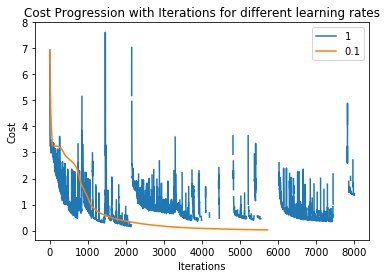

Best alpha is 0.1


In [10]:
# Get the best combination of weights and alpha
cache, alph = optimize()
print('Best alpha is ' + str(alph))

In [11]:
cache['A0'] = X_test_mat
ykey = 'A' + str(hiddenLayers+1)
cache2 = forward_propagate(cache, hiddenLayers, activationFuncs)
Afinal = softmax(cache2['A'+str(hiddenLayers)])
acc = get_accuracy(y_test, Afinal)
print('*****************Test Data************************')
print('Test Data Optimized accuracy is ' + str(acc))

*****************Test Data************************
Test Data Optimized accuracy is 91.6666666667
